# Director Skill Sets Table 7 - Appointments only

In [1]:
import pandas_datareader.data as web #to collect data
import datetime as dt #to specify start and end dates

# import yfinance as yf

import eventstudy as es
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mpl_toolkits as mplot3d
%matplotlib inline
import seaborn as sns

import scipy.stats as stats
from scipy.stats.mstats import winsorize
from scipy.spatial.distance import cdist


from sklearn.neighbors import NearestNeighbors

import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS

from patsy import dmatrices
from tqdm.notebook import tqdm
tqdm.pandas()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
import_folder_path = rf"..\..\..\[IN USE] Rookie Directors\[4] CAPM CAR precode\car_output4"
output_folder_path = "analysis_outputs"
pca_input_folder_path = rf"..\..\..\[IN USE] Rookie Directors\[1.5] Director Skills PCA\director_skills_pca"
supporting_folder_path = "supporting_datafiles"

In [5]:
dirFirm0 = pd.read_pickle(rf"{import_folder_path}\Director Level_MF_CAR.pkl")
pca = pd.read_pickle(rf"{pca_input_folder_path}\Main_Director_COMPLETE_PCA.pkl")

pca_col = [
    "Person Code", "AsOnDate", "Symbol",
    "SkillsetIndex", "SkillsetGeneralistDummy",
    "PC1_FactorScore", "PC1_FactorScore_Standardised"
]

pca2 = pca[pca_col].copy()
dirFirm = dirFirm0.merge(pca2, on = ["Person Code", "AsOnDate", "Symbol"], how = "left")

In [6]:
# dirFirm data wrangling if any:
dirFirm["Appointment Year"] = [x.year for x in dirFirm["Appointment Date"]]

dirFirm = dirFirm.drop_duplicates(subset = ["Person Code", "Company", "Appointment Date"]).reset_index(drop = True)

dirFirm["ln_dirage"] = np.log(dirFirm["Age"] + 1).astype("float")
dirFirm["ln_directorships"] = np.log(dirFirm["CompCountOtherPastTotalAB"] + 1).astype("float")

In [7]:
dirFirm.describe()

,AsOnDate,AsOnYear,Date of Birth,Tenure Valid till,Appointment Date,Cessation Date,PrevLastServed,NextServed,CessationDummy,ReappointDummy,TermStartDummy,TermNumber,AppointDummy,CumOpBalUnc,CumOpBalIndep,CumOpBalNonIndep,CumCloBalUnc,CumCloBalIndep,CumCloBalNonIndep,TermOpBalUnc,TermOpBalIndep,TermOpBalNonIndep,TermOpBalTotal,TermCloBalUnc,TermCloBalIndep,TermCloBalNonIndep,TermCloBalTotal,CompOpBalUnc,CompOpBalIndep,CompOpBalNonIndep,CompOpBalTotal,CompCloBalUnc,CompCloBalIndep,CompCloBalNonIndep,CompCloBalTotal,CloBalTotalXP,CountOtherPastUnclearA,CountOtherPastIndepA,CountOtherPastNonIndepA,CompCountOtherPastTotalA,CountOtherPastUnclearAB,CountOtherPastIndepAB,CountOtherPastNonIndepAB,CompCountOtherPastTotalAB,CountCurrUnclearA,CountCurrIndepA,CountCurrNonIndepA,CompCountCurrTotalA,CountCurrUnclearAB,CountCurrIndepAB,CountCurrNonIndepAB,CompCountCurrTotalAB,IsIndep,IsNonIndep,IsRookie,IsNonRookie,IsCeoMDPosition,IsChairmanPosition,IsCeoMDOccupation,IsChairmanOccupation,IsCeoMD,IsChairman,IsPromoterClassification,IsPromoterBoard,IsPromoter,IsDualityChairmanMD,IsFamilyManager,IsFamilyChairman,IsFamilyChairmanAndCEO,IsRookieIndep,IsRookieNonIndep,IsNonRookieIndep,IsNonRookieNonIndep,IsFemale,Age,TenureInYearsinCompIndep,TenureInYearsinCompTotal,IsFirstTerm,IsFirstTermIndep,IsOneYear,IsOneYearIndep,IsTwoYear,IsTwoYearIndep,IsThreeYear,IsThreeYearIndep,IsRetires5y,IsTermLimitRetirement,IsDefaultTerm,IsBusy,IsTurnOver,HasRetires5y,HasTermLimitRetirement,IsTurnOverIndep,Prowess company code,IsMBA,IsPhD,HasFinanceXP,HasTechXP,HasRelatedIndustryXP,IsExecCurrent,NumExecAll,IsOutsideExecXP,HasExecXP,PublicExecXPDummy,PrivateExecXPDummy,HasPublicExecXP,HasPrivateExecXP,HasTechSkill,HasFinanceSkill,NumSkills,NumFirmsPast,NumIndustryPast,HasCeoMDChairXP,HasConglomerateXP,skilllist_sustainability,skilllist_entrepreneurial,skilllist_compensation,skilllist_conglomerate_experience,skilllist_hr,skilllist_technology,skilllist_finance_accounting,skilllist_governance,skilllist_government_policy,skilllist_international,skilllist_leadership,skilllist_legal,skilllist_marketing,skilllist_risk_management,skilllist_scientific,skilllist_strategic_planning,skilllist_manufacturing_supply_chain,Academic,Manufacturing,Outside Board,Company Business,profile_sustainability,profile_entrepreneurial,profile_compensation,profile_conglomerate_experience,profile_hr,profile_technology,profile_finance_accounting,profile_governance,profile_government_policy,profile_international,profile_leadership,profile_legal,profile_marketing,profile_risk_management,profile_scientific,profile_strategic_planning,profile_manufacturing_supply_chain,committee_sustainability,committee_entrepreneurial,committee_compensation,committee_conglomerate_experience,committee_hr,committee_technology,committee_finance_accounting,committee_governance,committee_government_policy,committee_international,committee_leadership,committee_legal,committee_marketing,committee_risk_management,committee_scientific,committee_strategic_planning,committee_manufacturing_supply_chain,combined_sustainability,combined_entrepreneurial,combined_compensation,combined_conglomerate_experience,combined_hr,combined_technology,combined_finance_accounting,combined_governance,combined_government_policy,combined_international,combined_leadership,combined_legal,combined_marketing,combined_risk_management,combined_scientific,combined_strategic_planning,combined_manufacturing_supply_chain,NumSkills_dummies,Total No.of Board Meetings Held,No.of Meetings Attended,percent_board_absence,ProwessCode,ACP,pct,RF,RMRF,MF,SMB,HML,OLS120_intercept,OLS120_RMRF,OLS120_r_squared,OLS120_adjusted_r_squared,OLS120_f_p_value,120CAR3,120CAR5,120CAR7,120CAR11,OLS150_intercept,OLS150_RMRF,OLS150_r_squared,OLS150_adjusted_r_squared,OLS150_f_p_value,150CAR3,150CAR5,150CAR7,150CAR11,OLS180_intercept,OLS180_RMRF,OLS180_r_squared,OLS180_adjusted_r_squared,OLS180_f_p_value,180CAR3,180CAR5,180CAR7,180CAR11,OLS210_intercept,OLS210_RMRF,OLS210_r_squared,OLS

# PSM

## Verifying and removing those rows with no control data points

In [8]:
# Sample constraints ---> govtdummy==0 & findummy==0 & asonyear>2012
dirFirm.columns.to_list()

['Symbol',
 'Company',
 'AsOnDate',
 'AsOnYear',
 'ISIN',
 'Person Code',
 'Director Salutation',
 'Director First Name',
 'Director Middle Name',
 'Director Surname',
 'Date of Birth',
 'Gender',
 'Nationality',
 'Member of Civil Services',
 'Promoter Director (Yes/No)',
 'Position on Board',
 'Independent (Yes/No)',
 'Education1',
 'Education2',
 'Education3',
 'Education4',
 'Education5',
 'Education6',
 'Education7',
 'Education8',
 'Education9',
 'Education10',
 'Skills/Competencies',
 'Occupation',
 'Cessation Reason',
 'Other Directorship 1',
 'Other Directorship 2',
 'Other Directorship 3',
 'Other Directorship 4',
 'Other Directorship 5',
 'Other Directorship 6',
 'Other Directorship 7',
 'Other Directorship 8',
 'Other Directorship 9',
 'Other Directorship 10',
 'Other Directorship 11',
 'Other Directorship 12',
 'Other Directorship 13',
 'Other Directorship 14',
 'Other Directorship 15',
 'Brief Profile',
 'Tenure Valid till',
 'Indep',
 'Appointment Date',
 'Cessation Date'

In [9]:
dirFirm["IsDualityChairmanMD"] = dirFirm["IsDualityChairmanMD"].astype(int)


# dirFirm["NIC_2digit"] = dirFirm["NIC code"].dropna().apply(lambda x: x[0:2])
# dirFirm["NIC_2digit"] = dirFirm["NIC_2digit"]

psmSample = dirFirm.loc[ (dirFirm["Appointment Date"] >= "2013-03-31")].copy()
# \
# & (dirFirm["govtdummy"] == 0) & (dirFirm["findummy"] == 0) ].copy()
#.dropna(subset = controlVars).dropna(subset = dependentVar).copy()

psmSample["DummySum"] = psmSample["IsRookie"] + psmSample["IsNonRookie"]
psmSample["DummySumIndep"] = psmSample["IsRookieIndep"] + psmSample["IsNonRookieIndep"]

psmSampleAll = psmSample.loc[ psmSample["DummySum"] == 1 ].reset_index(drop = True)
#psmSampleAll = psmSampleAll.loc[ ~psmSampleAll.duplicated(subset = ["AsOnDate", "Symbol", "Appointment Date"], keep = False)]

psmSampleIndep = psmSample.loc[ psmSample["DummySumIndep"] == 1 ].reset_index(drop = True)
#psmSampleIndep = psmSampleIndep.loc[ ~psmSampleIndep.duplicated(subset = ["AsOnDate", "Symbol", "Appointment Date"], keep = False)]

In [10]:
# dirFirm2 = dirFirm.copy()
# psmSampleIndep2 = psmSampleIndep.copy()

# listCol = [
#     "FirstYearPCodeList", "TwoYearPCodeList", "ThreeYearPCodeList", "PCodeList",
#     "FirstYearIndepPCodeList", "TwoYearIndepPCodeList", "ThreeYearIndepPCodeList", "IndepPCodeList",
#     "OtherFirstYearIndepPCode", "OtherTwoYearIndepPCode", "OtherThreeYearIndepPCode", "TotalIndepPCode",
#     "OtherFirstYearPCode", "OtherTwoYearPCode", "OtherThreeYearPCode", "TotalPCode",
#     "OtherFirstYearPCodeIndepExcl","OtherTwoYearPCodeIndepExcl", "OtherThreeYearPCodeIndepExcl", "TotalPCodeIndepExcl",
#     "OtherFirstYearPCodeExcl", "OtherTwoYearPCodeExcl", "OtherThreeYearPCodeExcl", "TotalPCodeExcl"
# ]

# dirFirm2 = dirFirm2.drop(listCol, axis = 1)
# psmSampleIndep2 = psmSampleIndep2.drop(listCol, axis = 1)


# dirFirm2.to_csv("Main_Firm_PSM Ready_no filter v040425.csv")
# psmSampleIndep2.to_csv("Main_Firm_PSM Ready_filter-Indep_gov_fin v040425.csv")


# # # psmSampleAll --> 2101 rows 
# # psmSampleIndep --> 1561 rows 

## PSM --> RookieAppoints as Treatment, NonRookieAppoints as Control

In [11]:
def LogitReg(sample, endog_var, exog_var):
    
    # Logit Regression
    endog = sample[[endog_var]]
    exog = sample[exog_var]
    exog = sm.add_constant(exog)
    
    log_reg = sm.Logit(endog, exog).fit()

    propensityScores = log_reg.predict(exog)
    
    return propensityScores

In [12]:
def MeanDiffTtest(sample, endog_var, exog_var, car, depVar, dirFirm):

    sample[car] = winsorize(sample[car], limits = [0.01, 0.01])
    if depVar != None:
        dirFirm = dirFirm.rename( {depVar:f"{depVar}_2"}, axis = 1)
    
        colsAdd = []
        for i in range(-1, 4):
            if i != 0:
                colsAdd.append(f"AsOnYear_T+{i}")
                colsAdd.append(f"{depVar}T+{i}")
                if i>0 :
                    colsAdd.append(depVar+f"(T+{i}) - (T-1)")
    
        newFrame= pd.DataFrame(columns = colsAdd, data = 0, index = sample.index, dtype = "int")
        sample = pd.concat([sample, newFrame], axis = 1)
        sample = sample.copy()
        
        for i in range(-1, 4):
            if i != 0:
                sample.loc[:, f"AsOnYear_T+{i}"] = sample["AsOnYear"] + i
    
        for i in range(-1, 4):
            if i != 0:
                sample.loc[:, f"{depVar}T+{i}"] = sample.merge(dirFirm[["Symbol", "AsOnYear", f"{depVar}_2"]].copy(), left_on = ["Symbol", f"AsOnYear_T+{i}"],
                                                              right_on = ["Symbol", "AsOnYear"], how = "left")[f"{depVar}_2"]
        
        for i in range(1, 4):
            if i != 0:
                sample.loc[:, depVar+f"(T+{i}) - (T-1)"] = sample[f"{depVar}T+{i}"] - sample[f"{depVar}T+-1"]
    
            
        sample = sample.copy()
    
    group1 = sample.loc[ sample[endog_var] == 1].copy()
    group2 = sample.loc[ sample[endog_var] == 0].copy()
    
    t_stat, p_value = stats.ttest_ind(group1[car], group2[car], equal_var=False)  # Welch’s t-test (default)

    print("\n")
    print(car, ":")
    print("\n")
    print("T Statistic:", t_stat, " P Value:",p_value)
    print("Treated Mean:", group1[car].mean(), " Control Mean:", group2[car].mean(), " Diff:", group1[car].mean() - group2[car].mean())
    print("Treated Median:", group1[car].median(), " Control Median:", group2[car].median(), " Diff:", group1[car].median() - group2[car].median())
    print("Treated N:", len(group1[car]), "; Control N:", len(group2[car]))
    print("[treated unique = ", len(group1.loc[ :, ["Person Code", "Symbol", "AsOnDate"]].drop_duplicates()), "]",\
          "[control unique = ", len(group2.loc[ :, ["Person Code", "Symbol", "AsOnDate"]].drop_duplicates()), "]"
         )
    print("\n")

    # -----------------------------------------------------------------------------------------------------------------
    
    if exog_var != None:
        print("━"*120)
        print(f'{"Matching Variable":<40} {"Treatment Firms":<20} {"Control Firms":<20} {"Test of Diff (p value)":<20}')
        print(f'{" ":<40} {"N = " + str(len(group1[car])):<20} {"N = " + str(len(group2[car])):<20}')
        print("-"*120)

        for var in exog_var:
            treatMean = group1[var].mean()
            controlMean = group2[var].mean()
            p_value = stats.ttest_ind(group1[var], group2[var], equal_var=False)[1]
            print(f'{var:<40} {treatMean:<20.4f} {controlMean:<20.4f} {p_value:<20.4f}')
    
        print("━"*120, "\n")
    
    # -----------------------------------------------------------------------------------------------------------------


    if depVar != None:
        print(depVar, " across years:\n")
        for i in range(1,4):
            sample = sample.dropna(subset = [depVar+f'(T+{i}) - (T-1)'])
    
        group1 = sample.loc[ sample[endog_var] == 1].copy()
        group2 = sample.loc[ sample[endog_var] == 0].copy()

        print("━"*150, "\n")
        print(f'{depVar:<40}{" ":<20}{"Treatment Firms":<20}{"Control Firms":<20}{"Difference":<20}{"Test of Diff":<20}{"Test of Diff"}')
        print(f'{" ":<120}{"(t stat)":<20}{"(p value)":<20}')
    
        print("─"*150, "\n")
    
        for i in range(1,4):
            t_stat2, p_value2 = stats.ttest_ind(group1[depVar+f'(T+{i}) - (T-1)'], group2[depVar+f'(T+{i}) - (T-1)'], equal_var=False)  # Welch’s t-test (default)
            
            treatedMean = group1[depVar+f'(T+{i}) - (T-1)'].mean()
            controlMean = group2[depVar+f'(T+{i}) - (T-1)'].mean()
            diffMean = treatedMean - controlMean
    
            treatedMedian = group1[depVar+f'(T+{i}) - (T-1)'].median()
            controlMedian = group2[depVar+f'(T+{i}) - (T-1)'].median()
            diffMedian = treatedMedian - controlMedian
    
            print(f'{"Year_T+" + str(i) +" - Year_T-1":<40}{"<MEAN>":<20}{treatedMean:<20.4f}{controlMean:<20.4f}{diffMean:<20.4f}{t_stat2:<20.4f}{p_value2:<20.10f}')
    
            label1 = "Treated N: " + str(len(group1[depVar+f'(T+{i}) - (T-1)']))
            label2 = "Control N: " + str(len(group2[depVar+f'(T+{i}) - (T-1)']))
            
            print(f'{label1 + " "*5 + label2:<40}{"<MEDIAN>":<20}{treatedMedian:<20.4f}{controlMedian:<20.4f}{diffMedian:<20.4f}')
            
            print("-"*150, "\n")
            
        print("━"*150, "\n")

    return

In [13]:
def OneSampleTtest(sample, endog_var, exog_var, car, depVar, dirFirm):

    # if depVar != None:
    #     dirFirm = dirFirm.rename( {depVar:f"{depVar}_2"}, axis = 1)
    
    #     colsAdd = []
    #     for i in range(-1, 4):
    #         if i != 0:
    #             colsAdd.append(f"AsOnYear_T+{i}")
    #             colsAdd.append(f"{depVar}T+{i}")
    #             if i>0 :
    #                 colsAdd.append(depVar+f"(T+{i}) - (T-1)")
    
    #     newFrame= pd.DataFrame(columns = colsAdd, data = 0, index = sample.index, dtype = "int")
    #     sample = pd.concat([sample, newFrame], axis = 1)
    #     sample = sample.copy()
        
    #     for i in range(-1, 4):
    #         if i != 0:
    #             sample.loc[:, f"AsOnYear_T+{i}"] = sample["AsOnYear"] + i
    
    #     for i in range(-1, 4):
    #         if i != 0:
    #             sample.loc[:, f"{depVar}T+{i}"] = sample.merge(dirFirm[["Symbol", "AsOnYear", f"{depVar}_2"]].copy(), left_on = ["Symbol", f"AsOnYear_T+{i}"],
    #                                                           right_on = ["Symbol", "AsOnYear"], how = "left")[f"{depVar}_2"]
        
    #     for i in range(1, 4):
    #         if i != 0:
    #             sample.loc[:, depVar+f"(T+{i}) - (T-1)"] = sample[f"{depVar}T+{i}"] - sample[f"{depVar}T+-1"]
    
            
    #     sample = sample.copy()
    sample[car] = winsorize(sample[car], limits = [0.01, 0.01])
    group1 = sample.copy()
    
    t_stat, p_value = stats.ttest_1samp(group1[car], 0)  # Welch’s t-test (default)
    
    print("\n")
    print(car, ":")
    print("\n")
    print("T Statistic:", t_stat, " P Value:",p_value)
    print("Mean:", group1[car].mean())
    print("Median:", group1[car].median())
    print("N:", len(group1[car]))

    print("\n")

    # -----------------------------------------------------------------------------------------------------------------




    # if exog_var != None:
    #     print("━"*120)
    #     print(f'{"Matching Variable":<40} {"Treatment Firms":<20} {"Control Firms":<20} {"Test of Diff (p value)":<20}')
    #     print(f'{" ":<40} {"N = " + str(len(group1[car])):<20} {"N = " + str(len(group2[car])):<20}')
    #     print("-"*120)

    #     for var in exog_var:
    #         treatMean = group1[var].mean()
    #         controlMean = group2[var].mean()
    #         p_value = stats.ttest_ind(group1[var], group2[var], equal_var=False)[1]
    #         print(f'{var:<40} {treatMean:<20.4f} {controlMean:<20.4f} {p_value:<20.4f}')
    
    #     print("━"*120, "\n")
    
    # -----------------------------------------------------------------------------------------------------------------


    # if depVar != None:
    #     print(depVar, " across years:\n")
    #     for i in range(1,4):
    #         sample = sample.dropna(subset = [depVar+f'(T+{i}) - (T-1)'])
    
    #     group1 = sample.loc[ sample[endog_var] == 1].copy()
    #     group2 = sample.loc[ sample[endog_var] == 0].copy()

    #     print("━"*150, "\n")
    #     print(f'{depVar:<40}{" ":<20}{"Treatment Firms":<20}{"Control Firms":<20}{"Difference":<20}{"Test of Diff":<20}{"Test of Diff"}')
    #     print(f'{" ":<120}{"(t stat)":<20}{"(p value)":<20}')
    
    #     print("─"*150, "\n")
    
    #     for i in range(1,4):
    #         t_stat2, p_value2 = stats.ttest_ind(group1[depVar+f'(T+{i}) - (T-1)'], group2[depVar+f'(T+{i}) - (T-1)'], equal_var=False)  # Welch’s t-test (default)
            
    #         treatedMean = group1[depVar+f'(T+{i}) - (T-1)'].mean()
    #         controlMean = group2[depVar+f'(T+{i}) - (T-1)'].mean()
    #         diffMean = treatedMean - controlMean
    
    #         treatedMedian = group1[depVar+f'(T+{i}) - (T-1)'].median()
    #         controlMedian = group2[depVar+f'(T+{i}) - (T-1)'].median()
    #         diffMedian = treatedMedian - controlMedian
    
    #         print(f'{"Year_T+" + str(i) +" - Year_T-1":<40}{"<MEAN>":<20}{treatedMean:<20.4f}{controlMean:<20.4f}{diffMean:<20.4f}{t_stat2:<20.4f}{p_value2:<20.10f}')
    
    #         label1 = "Treated N: " + str(len(group1[depVar+f'(T+{i}) - (T-1)']))
    #         label2 = "Control N: " + str(len(group1[depVar+f'(T+{i}) - (T-1)']))
            
    #         print(f'{label1 + " "*5 + label2:<40}{"<MEDIAN>":<20}{treatedMedian:<20.4f}{controlMedian:<20.4f}{diffMedian:<20.4f}')
            
    #         print("-"*150, "\n")
            
    #print("━"*150, "\n")

    return

In [14]:
def PsmReplac(sample, endog_var, exog_var, car, depVar, dirFirm):

    # Logit Regression
    sample.loc[:, "propensityScore"] = LogitReg(sample, endog_var, exog_var)

    treated = sample.loc[ sample[endog_var] == 1].copy()
    control = sample.loc[ sample[endog_var] == 0].copy()

    # Nearest Neighbours
    nn = NearestNeighbors(n_neighbors = 1, metric = "euclidean")
    nn.fit(control[["propensityScore"]])

    distances, indices = nn.kneighbors(treated[["propensityScore"]])
    
    matchedControl = control.iloc[indices.flatten()].copy()
    
    matched = pd.concat([treated, matchedControl])
    matched.reset_index(drop=True, inplace=True)

    MeanDiffTtest(matched, endog_var, exog_var, car, depVar, dirFirm)

    return

In [15]:
# Func PSM non replacement
def PsmNonReplac(sample, endog_var, exog_var, car, depVar, dirFirm):

    # Logit Regression
    sample.loc[:, "propensityScore"] = LogitReg(sample, endog_var, exog_var)

    # Separate treated and control groups
    treated = sample[sample[endog_var] == 1].copy()
    control = sample[sample[endog_var] == 0].copy()
    
    # Compute pairwise distances (absolute difference in propensity scores)
    dist_matrix = cdist(treated[['propensityScore']], control[['propensityScore']], metric='euclidean')
    
    # Match without replacement
    treated_indices = []
    matched_indices = []
    used_control_indices = set()
    
    for i in range(len(treated)):
        if len(used_control_indices) >= len(control):  # Stop if no controls left
            print("Warning: Not enough control units to match all treated units.")
            break
        
        # Get nearest control unit index that hasn't been used
        match_idx = np.argmin(dist_matrix[i])
        
        while match_idx in used_control_indices:  # Ensure it's not already matched
            dist_matrix[i, match_idx] = np.inf  # Temporarily set distance to infinity

            if np.all(dist_matrix[i] == np.inf):  # If all controls are exhausted
                print(f"No available control for treated unit {i}, skipping.")
                match_idx = None
                break
            
            match_idx = np.argmin(dist_matrix[i])
        
        used_control_indices.add(match_idx)
        matched_indices.append(match_idx)
        treated_indices.append(i)
    
    # Retrieve matched units
    matched_control = control.iloc[matched_indices].copy()
    matched_treated = treated.iloc[treated_indices].copy()
    
    # Combine matched treated and control units
    matched_data = pd.concat([matched_treated.reset_index(drop=True), matched_control.reset_index(drop=True)])
    
    # Reset index
    matched_data.reset_index(drop=True, inplace=True)


    # Mean difference and T Test
    MeanDiffTtest(matched_data, endog_var, exog_var, car, depVar, dirFirm)

    return
    


In [16]:
psmSampleIndep

,Symbol,Company,AsOnDate,AsOnYear,ISIN,Person Code,Director Salutation,Director First Name,Director Middle Name,Director Surname,Date of Birth,Gender,Nationality,Member of Civil Services,Promoter Director (Yes/No),Position on Board,Independent (Yes/No),Education1,Education2,Education3,Education4,Education5,Education6,Education7,Education8,Education9,Education10,Skills/Competencies,Occupation,Cessation Reason,Other Directorship 1,Other Directorship 2,Other Directorship 3,Other Directorship 4,Other Directorship 5,Other Directorship 6,Other Directorship 7,Other Directorship 8,Other Directorship 9,Other Directorship 10,Other Directorship 11,Other Directorship 12,Other Directorship 13,Other Directorship 14,Other Directorship 15,Brief Profile,Tenure Valid till,Indep,Appointment Date,Cessation Date,PrevLastServed,NextServed,CessationDummy,ReappointDummy,TermStartDummy,TermNumber,AppointDummy,CumOpBalUnc,CumOpBalIndep,CumOpBalNonIndep,CumCloBalUnc,CumCloBalIndep,CumCloBalNonIndep,TermOpBalUnc,TermOpBalIndep,TermOpBalNonIndep,TermOpBalTotal,TermCloBalUnc,TermCloBalIndep,TermCloBalNonIndep,TermCloBalTotal,CompOpBalUnc,CompOpBalIndep,CompOpBalNonIndep,CompOpBalTotal,CompCloBalUnc,CompCloBalIndep,CompCloBalNonIndep,CompCloBalTotal,CloBalTotalXP,AllPastDirect,CurrDirectA,CurrDirectAB,PastSiezedDirectA,PastSiezedDirectAB,CountOtherPastUnclearA,CountOtherPastIndepA,CountOtherPastNonIndepA,CompCountOtherPastTotalA,CountOtherPastUnclearAB,CountOtherPastIndepAB,CountOtherPastNonIndepAB,CompCountOtherPastTotalAB,CountCurrUnclearA,CountCurrIndepA,CountCurrNonIndepA,CompCountCurrTotalA,CountCurrUnclearAB,CountCurrIndepAB,CountCurrNonIndepAB,CompCountCurrTotalAB,Rookie,IsIndep,IsNonIndep,IsRookie,IsNonRookie,IsCeoMDPosition,IsChairmanPosition,IsCeoMDOccupation,IsChairmanOccupation,IsCeoMD,IsChairman,IsPromoterClassification,IsPromoterBoard,IsPromoter,IsDualityChairmanMD,IsFamilyManager,IsFamilyChairman,IsFamilyChairmanAndCEO,IsRookieIndep,IsRookieNonIndep,IsNonRookieIndep,IsNonRookieNonIndep,IsFemale,Age,TenureInYearsinCompIndep,TenureInYearsinCompTotal,IsFirstTerm,IsFirstTermIndep,IsOneYear,IsOneYearIndep,IsTwoYear,IsTwoYearIndep,IsThreeYear,IsThreeYearIndep,IsRetires5y,IsTermLimitRetirement,IsDefaultTerm,IsBusy,IsTurnOver,HasRetires5y,HasTermLimitRetirement,IsTurnOverIndep,NSE symbol,NIC code,Entity type,Ownership group,Prowess company code,CompanyName,Skills,EducationAll,IsMBA,IsPhD,AllPastDirectNIC,CurrDirectANIC,CurrDirectABNIC,AllNIC,AllNIC_Industry,HasFinanceXP,HasTechXP,HasRelatedIndustryXP,IsExecCurrent,NumExecAll,IsOutsideExecXP,HasExecXP,PublicExecXPDummy,PrivateExecXPDummy,HasPublicExecXP,HasPrivateExecXP,SkillsInPositiononBoard,SkillsInOccupation,AllSkills,HasTechSkill,HasFinanceSkill,FirmsPast,NumSkills,NumFirmsPast,NumIndustryPast,HasCeoMDChairXP,HasConglomerateXP,skilllist_sustainability,skilllist_entrepreneurial,skilllist_compensation,skilllist_conglomerate_experience,skilllist_hr,skilllist_technology,skilllist_finance_accounting,skilllist_governance,skilllist_government_policy,skilllist_international,skilllist_leadership,skilllist_legal,skilllist_marketing,skilllist_risk_management,skilllist_scientific,skilllist_strategic_planning,skilllist_manufacturing_supply_chain,Academic,Manufacturing,Outside Board,Company Business,profile_sustainability,profile_entrepreneurial,profile_compensation,profile_conglomerate_experience,profile_hr,profile_technology,profile_finance_accounting,profile_governance,profile_government_policy,profile_international,profile_leadership,profile_legal,profile_marketing,profile_risk_management,profile_scientific,profile_strategic_planning,profile_manufacturing_supply_chain,Committee Name,committee_sustainability,committee_entrepreneurial,committee_compensation,committee_conglomerate_experience,committee_hr,committee_technology,committee_finance_accounting,committee_governance,committee_government_policy,committee_international,committee_leadership,committee_legal,committee_marketing,committee_risk_management,co

# CAR Plots

### Total Sample

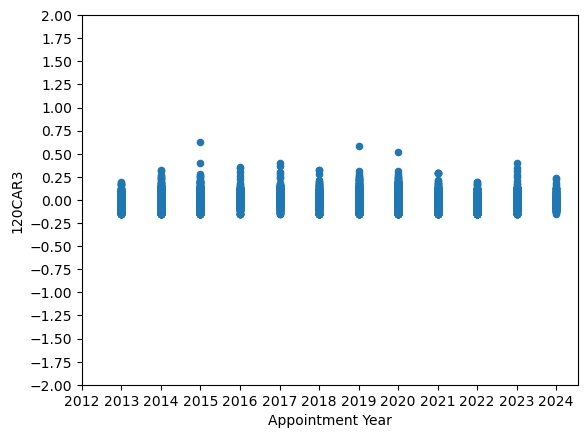

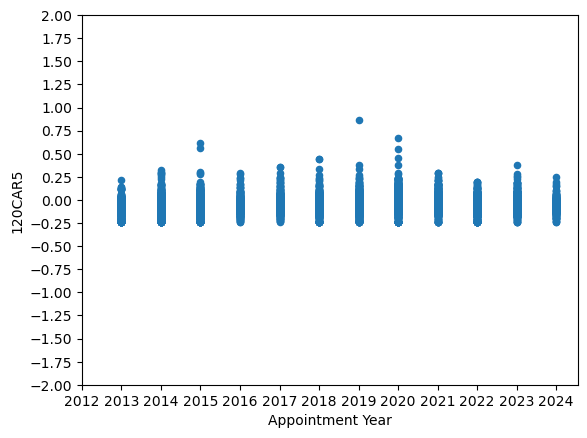

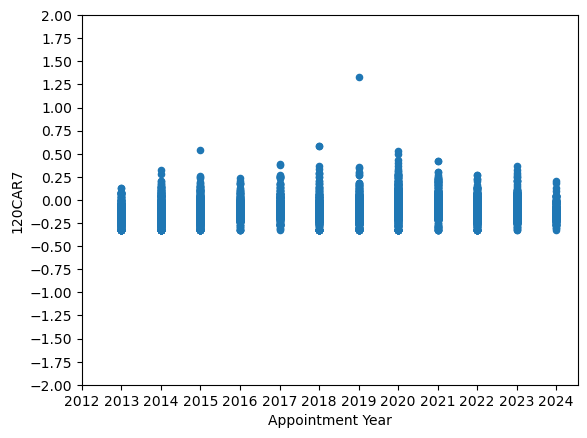

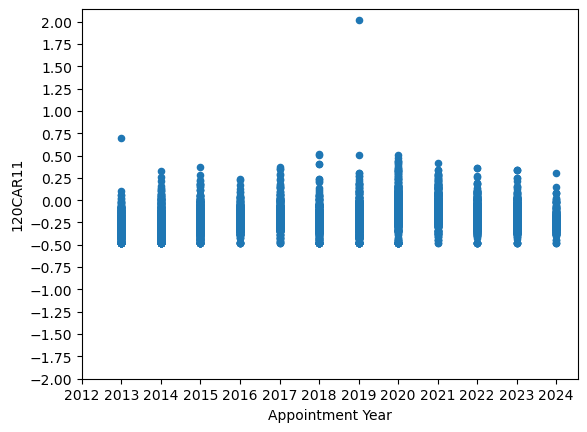

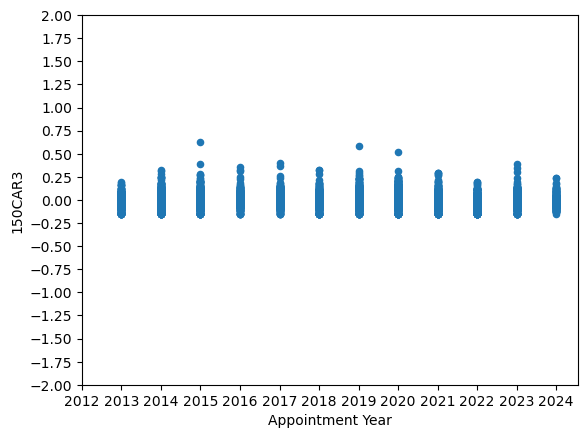

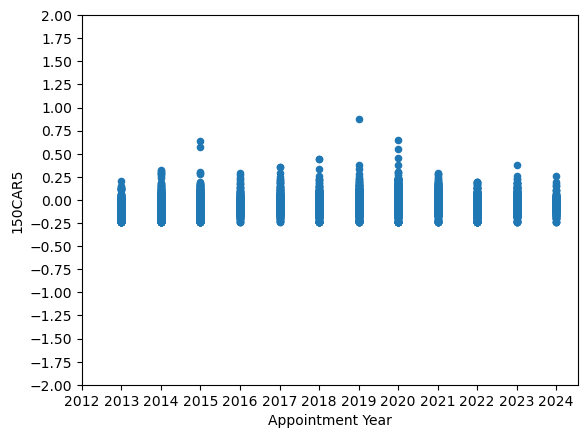

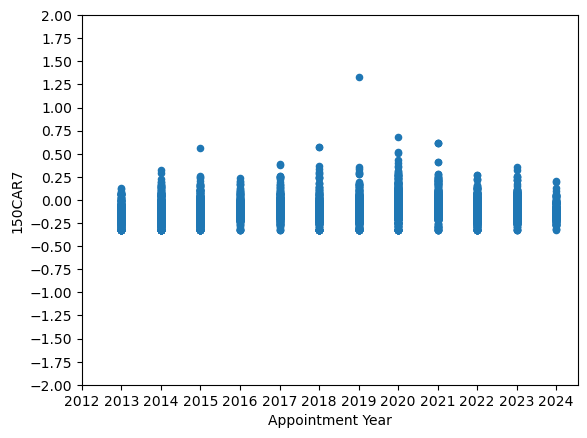

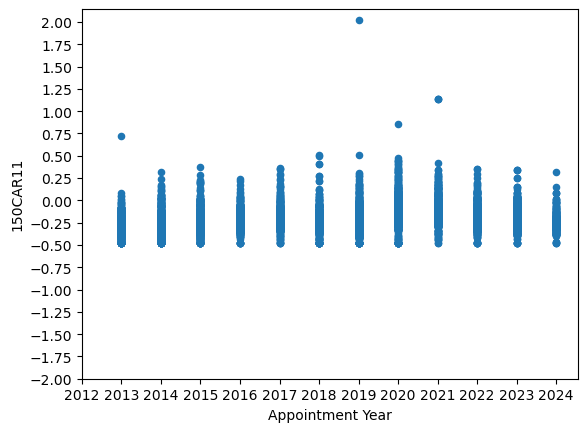

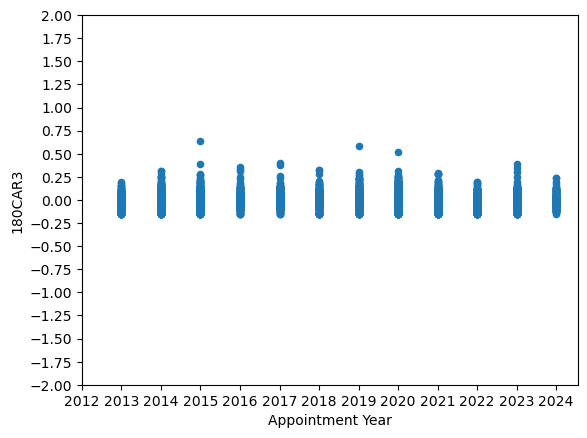

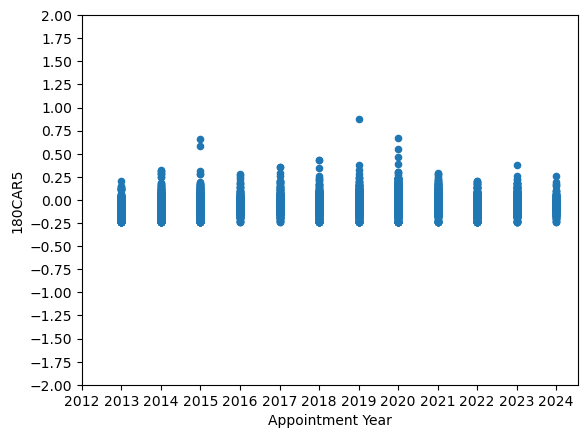

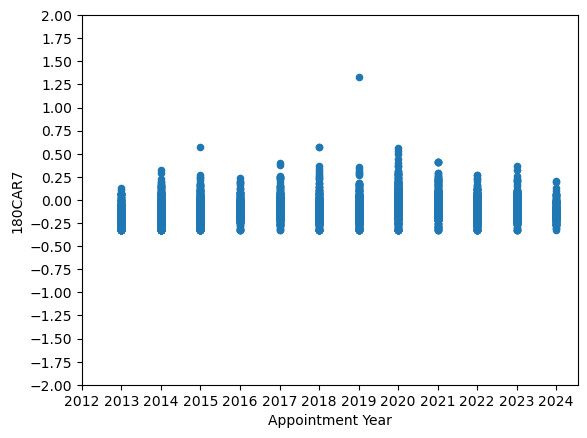

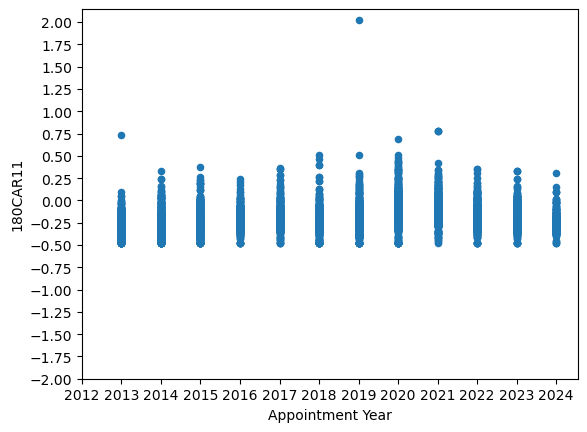

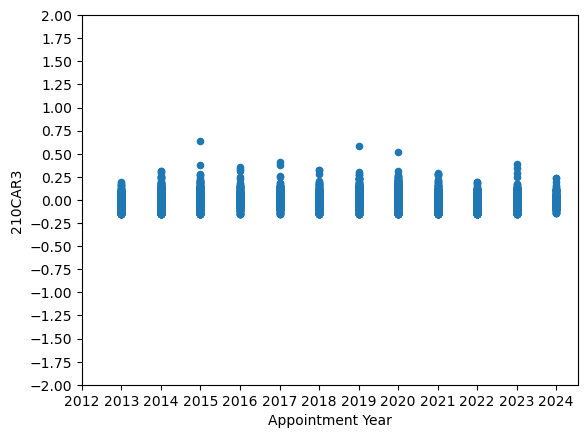

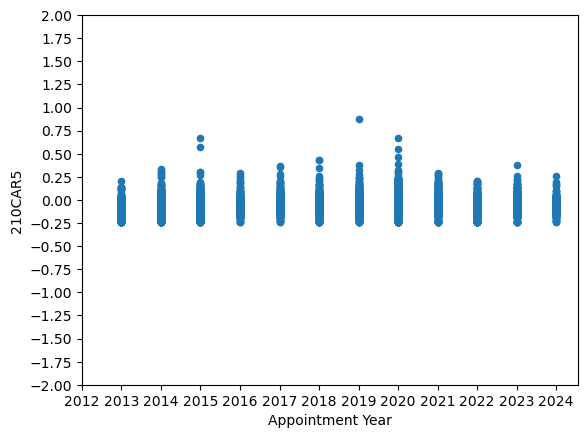

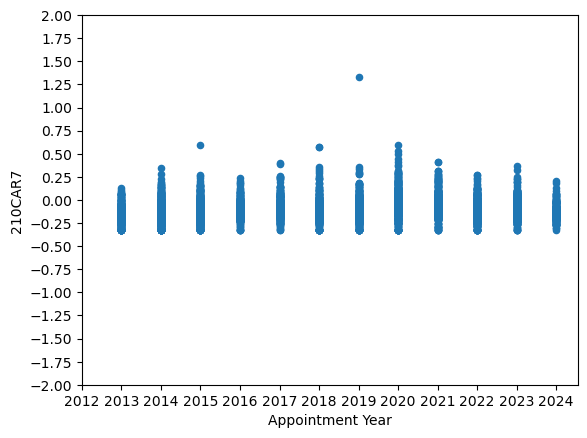

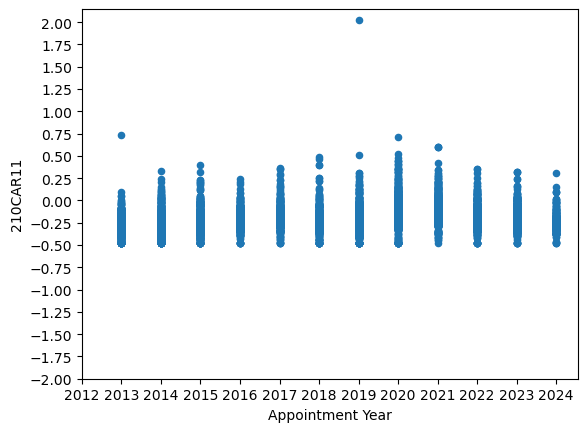

In [17]:
test = psmSampleIndep.copy()

carCol = ["120CAR3", "120CAR5", "120CAR7", "120CAR11", 
          "150CAR3", "150CAR5", "150CAR7", "150CAR11", 
          "180CAR3", "180CAR5", "180CAR7", "180CAR11",
          "210CAR3", "210CAR5", "210CAR7", "210CAR11"]

for car in carCol:
    test[car] = winsorize(test[car].values, limits = [0.01, 0.01]).data
    test[[car, "Appointment Year"]].plot(kind = "scatter", x="Appointment Year", y=car, xticks = np.arange(2012, 2025, step = 1), yticks = np.arange(-2, 2.25, step = 0.25))

In [18]:
test.describe()

,AsOnDate,AsOnYear,Date of Birth,Tenure Valid till,Appointment Date,Cessation Date,PrevLastServed,NextServed,CessationDummy,ReappointDummy,TermStartDummy,TermNumber,AppointDummy,CumOpBalUnc,CumOpBalIndep,CumOpBalNonIndep,CumCloBalUnc,CumCloBalIndep,CumCloBalNonIndep,TermOpBalUnc,TermOpBalIndep,TermOpBalNonIndep,TermOpBalTotal,TermCloBalUnc,TermCloBalIndep,TermCloBalNonIndep,TermCloBalTotal,CompOpBalUnc,CompOpBalIndep,CompOpBalNonIndep,CompOpBalTotal,CompCloBalUnc,CompCloBalIndep,CompCloBalNonIndep,CompCloBalTotal,CloBalTotalXP,CountOtherPastUnclearA,CountOtherPastIndepA,CountOtherPastNonIndepA,CompCountOtherPastTotalA,CountOtherPastUnclearAB,CountOtherPastIndepAB,CountOtherPastNonIndepAB,CompCountOtherPastTotalAB,CountCurrUnclearA,CountCurrIndepA,CountCurrNonIndepA,CompCountCurrTotalA,CountCurrUnclearAB,CountCurrIndepAB,CountCurrNonIndepAB,CompCountCurrTotalAB,IsIndep,IsNonIndep,IsRookie,IsNonRookie,IsCeoMDPosition,IsChairmanPosition,IsCeoMDOccupation,IsChairmanOccupation,IsCeoMD,IsChairman,IsPromoterClassification,IsPromoterBoard,IsPromoter,IsDualityChairmanMD,IsFamilyManager,IsFamilyChairman,IsFamilyChairmanAndCEO,IsRookieIndep,IsRookieNonIndep,IsNonRookieIndep,IsNonRookieNonIndep,IsFemale,Age,TenureInYearsinCompIndep,TenureInYearsinCompTotal,IsFirstTerm,IsFirstTermIndep,IsOneYear,IsOneYearIndep,IsTwoYear,IsTwoYearIndep,IsThreeYear,IsThreeYearIndep,IsRetires5y,IsTermLimitRetirement,IsDefaultTerm,IsBusy,IsTurnOver,HasRetires5y,HasTermLimitRetirement,IsTurnOverIndep,Prowess company code,IsMBA,IsPhD,HasFinanceXP,HasTechXP,HasRelatedIndustryXP,IsExecCurrent,NumExecAll,IsOutsideExecXP,HasExecXP,PublicExecXPDummy,PrivateExecXPDummy,HasPublicExecXP,HasPrivateExecXP,HasTechSkill,HasFinanceSkill,NumSkills,NumFirmsPast,NumIndustryPast,HasCeoMDChairXP,HasConglomerateXP,skilllist_sustainability,skilllist_entrepreneurial,skilllist_compensation,skilllist_conglomerate_experience,skilllist_hr,skilllist_technology,skilllist_finance_accounting,skilllist_governance,skilllist_government_policy,skilllist_international,skilllist_leadership,skilllist_legal,skilllist_marketing,skilllist_risk_management,skilllist_scientific,skilllist_strategic_planning,skilllist_manufacturing_supply_chain,Academic,Manufacturing,Outside Board,Company Business,profile_sustainability,profile_entrepreneurial,profile_compensation,profile_conglomerate_experience,profile_hr,profile_technology,profile_finance_accounting,profile_governance,profile_government_policy,profile_international,profile_leadership,profile_legal,profile_marketing,profile_risk_management,profile_scientific,profile_strategic_planning,profile_manufacturing_supply_chain,committee_sustainability,committee_entrepreneurial,committee_compensation,committee_conglomerate_experience,committee_hr,committee_technology,committee_finance_accounting,committee_governance,committee_government_policy,committee_international,committee_leadership,committee_legal,committee_marketing,committee_risk_management,committee_scientific,committee_strategic_planning,committee_manufacturing_supply_chain,combined_sustainability,combined_entrepreneurial,combined_compensation,combined_conglomerate_experience,combined_hr,combined_technology,combined_finance_accounting,combined_governance,combined_government_policy,combined_international,combined_leadership,combined_legal,combined_marketing,combined_risk_management,combined_scientific,combined_strategic_planning,combined_manufacturing_supply_chain,NumSkills_dummies,Total No.of Board Meetings Held,No.of Meetings Attended,percent_board_absence,ProwessCode,ACP,pct,RF,RMRF,MF,SMB,HML,OLS120_intercept,OLS120_RMRF,OLS120_r_squared,OLS120_adjusted_r_squared,OLS120_f_p_value,120CAR3,120CAR5,120CAR7,120CAR11,OLS150_intercept,OLS150_RMRF,OLS150_r_squared,OLS150_adjusted_r_squared,OLS150_f_p_value,150CAR3,150CAR5,150CAR7,150CAR11,OLS180_intercept,OLS180_RMRF,OLS180_r_squared,OLS180_adjusted_r_squared,OLS180_f_p_value,180CAR3,180CAR5,180CAR7,180CAR11,OLS210_intercept,OLS210_RMRF,OLS210_r_squared,OLS

### RID

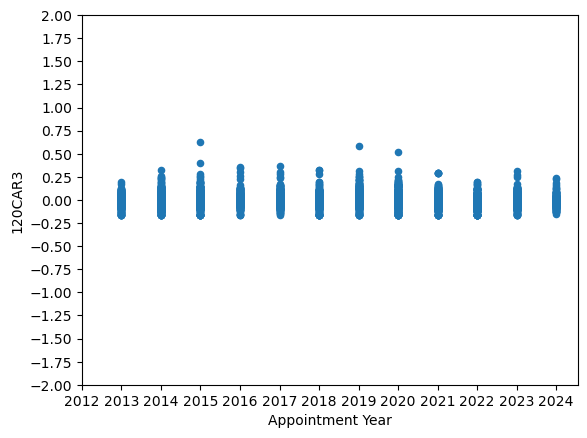

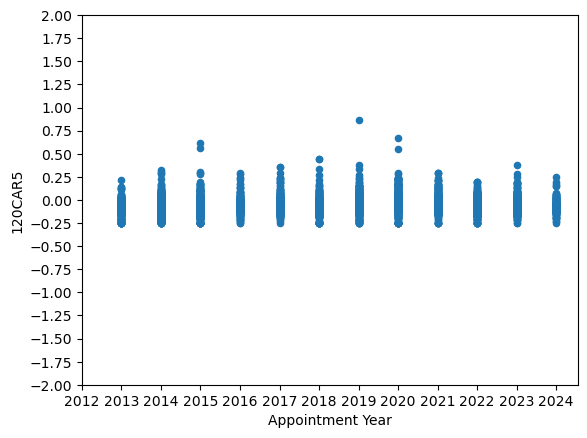

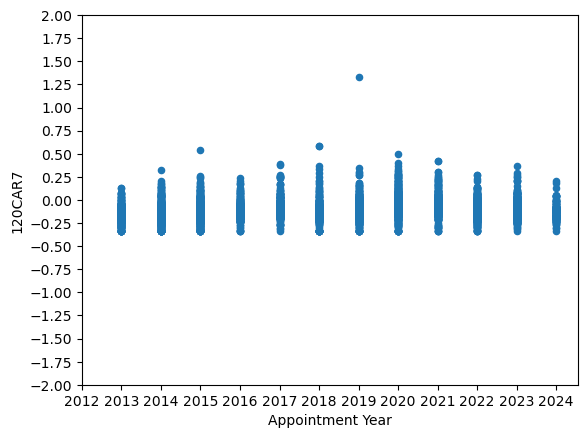

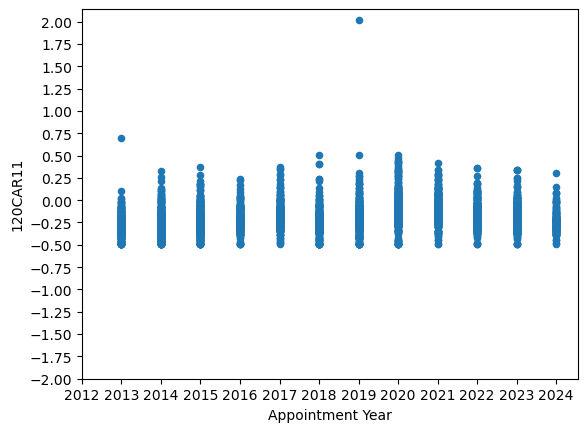

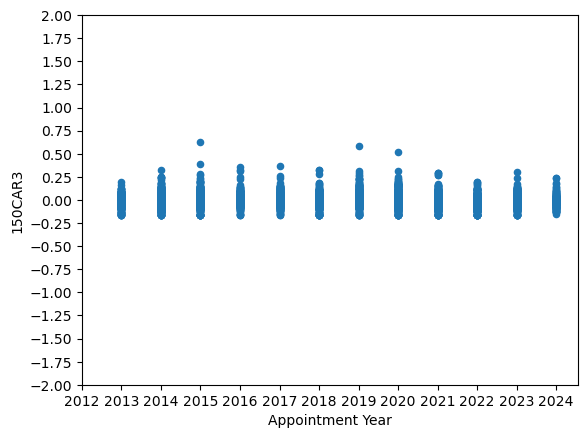

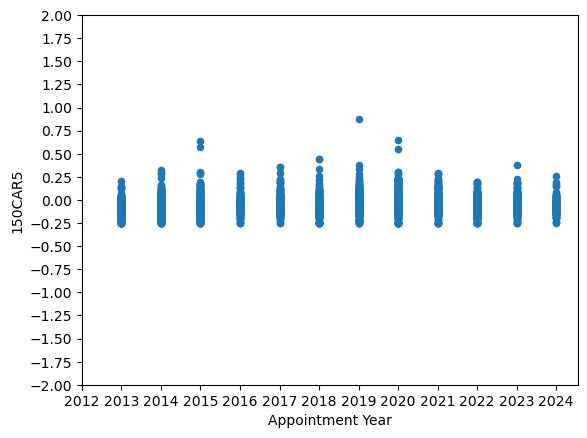

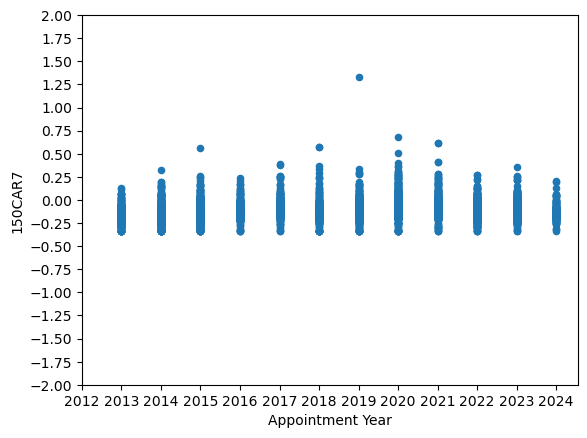

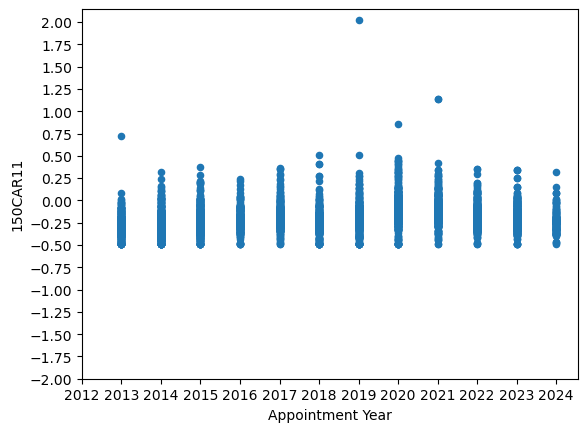

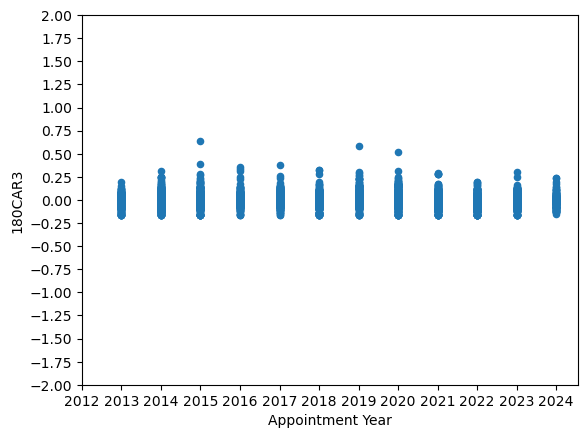

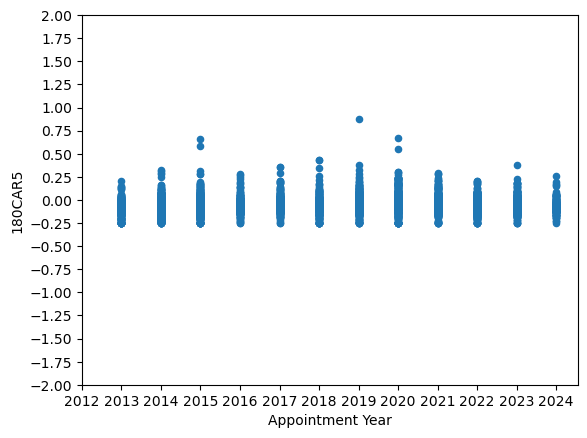

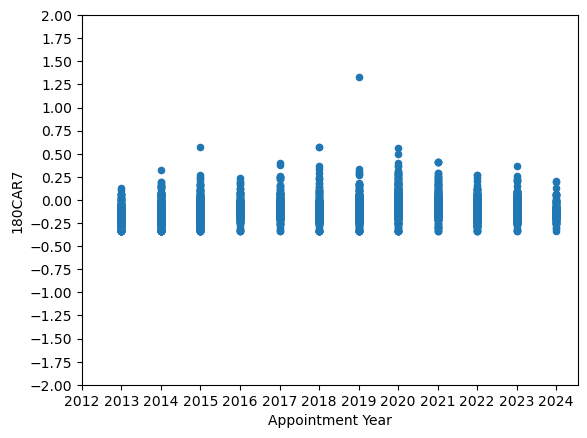

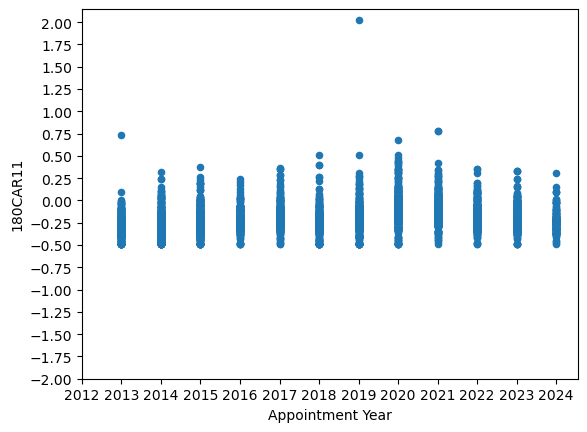

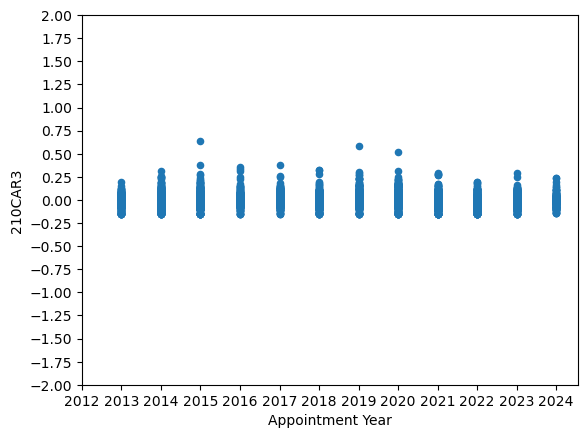

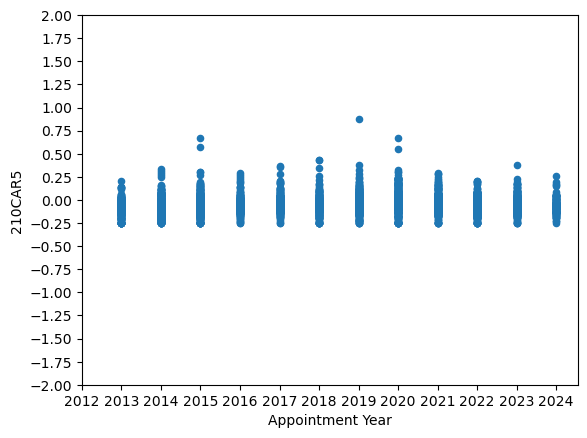

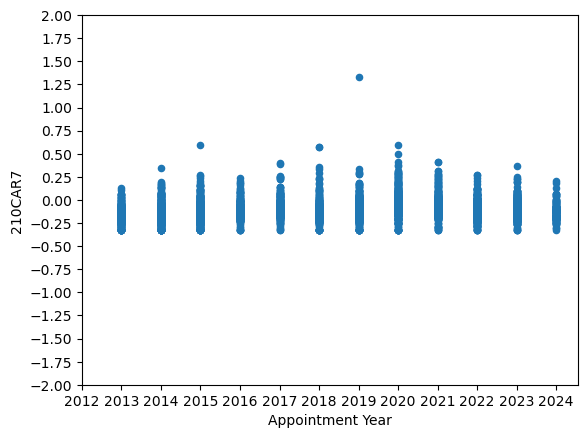

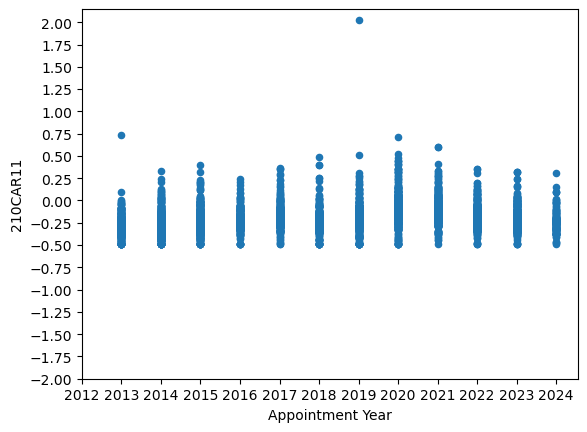

In [19]:
test = psmSampleIndep.loc[ psmSampleIndep["IsRookieIndep"] == 1 ].copy()

carCol = ["120CAR3", "120CAR5", "120CAR7", "120CAR11", 
          "150CAR3", "150CAR5", "150CAR7", "150CAR11", 
          "180CAR3", "180CAR5", "180CAR7", "180CAR11",
          "210CAR3", "210CAR5", "210CAR7", "210CAR11"]

for car in carCol:
    test[car] = winsorize(test[car].values, limits = [0.01, 0.01]).data
    test[[car, "Appointment Year"]].plot(kind = "scatter", x="Appointment Year", y=car, xticks = np.arange(2012, 2025, step = 1), yticks = np.arange(-2, 2.25, step = 0.25))

In [20]:
test.describe()

,AsOnDate,AsOnYear,Date of Birth,Tenure Valid till,Appointment Date,Cessation Date,PrevLastServed,NextServed,CessationDummy,ReappointDummy,TermStartDummy,TermNumber,AppointDummy,CumOpBalUnc,CumOpBalIndep,CumOpBalNonIndep,CumCloBalUnc,CumCloBalIndep,CumCloBalNonIndep,TermOpBalUnc,TermOpBalIndep,TermOpBalNonIndep,TermOpBalTotal,TermCloBalUnc,TermCloBalIndep,TermCloBalNonIndep,TermCloBalTotal,CompOpBalUnc,CompOpBalIndep,CompOpBalNonIndep,CompOpBalTotal,CompCloBalUnc,CompCloBalIndep,CompCloBalNonIndep,CompCloBalTotal,CloBalTotalXP,CountOtherPastUnclearA,CountOtherPastIndepA,CountOtherPastNonIndepA,CompCountOtherPastTotalA,CountOtherPastUnclearAB,CountOtherPastIndepAB,CountOtherPastNonIndepAB,CompCountOtherPastTotalAB,CountCurrUnclearA,CountCurrIndepA,CountCurrNonIndepA,CompCountCurrTotalA,CountCurrUnclearAB,CountCurrIndepAB,CountCurrNonIndepAB,CompCountCurrTotalAB,IsIndep,IsNonIndep,IsRookie,IsNonRookie,IsCeoMDPosition,IsChairmanPosition,IsCeoMDOccupation,IsChairmanOccupation,IsCeoMD,IsChairman,IsPromoterClassification,IsPromoterBoard,IsPromoter,IsDualityChairmanMD,IsFamilyManager,IsFamilyChairman,IsFamilyChairmanAndCEO,IsRookieIndep,IsRookieNonIndep,IsNonRookieIndep,IsNonRookieNonIndep,IsFemale,Age,TenureInYearsinCompIndep,TenureInYearsinCompTotal,IsFirstTerm,IsFirstTermIndep,IsOneYear,IsOneYearIndep,IsTwoYear,IsTwoYearIndep,IsThreeYear,IsThreeYearIndep,IsRetires5y,IsTermLimitRetirement,IsDefaultTerm,IsBusy,IsTurnOver,HasRetires5y,HasTermLimitRetirement,IsTurnOverIndep,Prowess company code,IsMBA,IsPhD,HasFinanceXP,HasTechXP,HasRelatedIndustryXP,IsExecCurrent,NumExecAll,IsOutsideExecXP,HasExecXP,PublicExecXPDummy,PrivateExecXPDummy,HasPublicExecXP,HasPrivateExecXP,HasTechSkill,HasFinanceSkill,NumSkills,NumFirmsPast,NumIndustryPast,HasCeoMDChairXP,HasConglomerateXP,skilllist_sustainability,skilllist_entrepreneurial,skilllist_compensation,skilllist_conglomerate_experience,skilllist_hr,skilllist_technology,skilllist_finance_accounting,skilllist_governance,skilllist_government_policy,skilllist_international,skilllist_leadership,skilllist_legal,skilllist_marketing,skilllist_risk_management,skilllist_scientific,skilllist_strategic_planning,skilllist_manufacturing_supply_chain,Academic,Manufacturing,Outside Board,Company Business,profile_sustainability,profile_entrepreneurial,profile_compensation,profile_conglomerate_experience,profile_hr,profile_technology,profile_finance_accounting,profile_governance,profile_government_policy,profile_international,profile_leadership,profile_legal,profile_marketing,profile_risk_management,profile_scientific,profile_strategic_planning,profile_manufacturing_supply_chain,committee_sustainability,committee_entrepreneurial,committee_compensation,committee_conglomerate_experience,committee_hr,committee_technology,committee_finance_accounting,committee_governance,committee_government_policy,committee_international,committee_leadership,committee_legal,committee_marketing,committee_risk_management,committee_scientific,committee_strategic_planning,committee_manufacturing_supply_chain,combined_sustainability,combined_entrepreneurial,combined_compensation,combined_conglomerate_experience,combined_hr,combined_technology,combined_finance_accounting,combined_governance,combined_government_policy,combined_international,combined_leadership,combined_legal,combined_marketing,combined_risk_management,combined_scientific,combined_strategic_planning,combined_manufacturing_supply_chain,NumSkills_dummies,Total No.of Board Meetings Held,No.of Meetings Attended,percent_board_absence,ProwessCode,ACP,pct,RF,RMRF,MF,SMB,HML,OLS120_intercept,OLS120_RMRF,OLS120_r_squared,OLS120_adjusted_r_squared,OLS120_f_p_value,120CAR3,120CAR5,120CAR7,120CAR11,OLS150_intercept,OLS150_RMRF,OLS150_r_squared,OLS150_adjusted_r_squared,OLS150_f_p_value,150CAR3,150CAR5,150CAR7,150CAR11,OLS180_intercept,OLS180_RMRF,OLS180_r_squared,OLS180_adjusted_r_squared,OLS180_f_p_value,180CAR3,180CAR5,180CAR7,180CAR11,OLS210_intercept,OLS210_RMRF,OLS210_r_squared,OLS

In [21]:
test.loc[ test["120CAR5"] >= 0.75]

,Symbol,Company,AsOnDate,AsOnYear,ISIN,Person Code,Director Salutation,Director First Name,Director Middle Name,Director Surname,Date of Birth,Gender,Nationality,Member of Civil Services,Promoter Director (Yes/No),Position on Board,Independent (Yes/No),Education1,Education2,Education3,Education4,Education5,Education6,Education7,Education8,Education9,Education10,Skills/Competencies,Occupation,Cessation Reason,Other Directorship 1,Other Directorship 2,Other Directorship 3,Other Directorship 4,Other Directorship 5,Other Directorship 6,Other Directorship 7,Other Directorship 8,Other Directorship 9,Other Directorship 10,Other Directorship 11,Other Directorship 12,Other Directorship 13,Other Directorship 14,Other Directorship 15,Brief Profile,Tenure Valid till,Indep,Appointment Date,Cessation Date,PrevLastServed,NextServed,CessationDummy,ReappointDummy,TermStartDummy,TermNumber,AppointDummy,CumOpBalUnc,CumOpBalIndep,CumOpBalNonIndep,CumCloBalUnc,CumCloBalIndep,CumCloBalNonIndep,TermOpBalUnc,TermOpBalIndep,TermOpBalNonIndep,TermOpBalTotal,TermCloBalUnc,TermCloBalIndep,TermCloBalNonIndep,TermCloBalTotal,CompOpBalUnc,CompOpBalIndep,CompOpBalNonIndep,CompOpBalTotal,CompCloBalUnc,CompCloBalIndep,CompCloBalNonIndep,CompCloBalTotal,CloBalTotalXP,AllPastDirect,CurrDirectA,CurrDirectAB,PastSiezedDirectA,PastSiezedDirectAB,CountOtherPastUnclearA,CountOtherPastIndepA,CountOtherPastNonIndepA,CompCountOtherPastTotalA,CountOtherPastUnclearAB,CountOtherPastIndepAB,CountOtherPastNonIndepAB,CompCountOtherPastTotalAB,CountCurrUnclearA,CountCurrIndepA,CountCurrNonIndepA,CompCountCurrTotalA,CountCurrUnclearAB,CountCurrIndepAB,CountCurrNonIndepAB,CompCountCurrTotalAB,Rookie,IsIndep,IsNonIndep,IsRookie,IsNonRookie,IsCeoMDPosition,IsChairmanPosition,IsCeoMDOccupation,IsChairmanOccupation,IsCeoMD,IsChairman,IsPromoterClassification,IsPromoterBoard,IsPromoter,IsDualityChairmanMD,IsFamilyManager,IsFamilyChairman,IsFamilyChairmanAndCEO,IsRookieIndep,IsRookieNonIndep,IsNonRookieIndep,IsNonRookieNonIndep,IsFemale,Age,TenureInYearsinCompIndep,TenureInYearsinCompTotal,IsFirstTerm,IsFirstTermIndep,IsOneYear,IsOneYearIndep,IsTwoYear,IsTwoYearIndep,IsThreeYear,IsThreeYearIndep,IsRetires5y,IsTermLimitRetirement,IsDefaultTerm,IsBusy,IsTurnOver,HasRetires5y,HasTermLimitRetirement,IsTurnOverIndep,NSE symbol,NIC code,Entity type,Ownership group,Prowess company code,CompanyName,Skills,EducationAll,IsMBA,IsPhD,AllPastDirectNIC,CurrDirectANIC,CurrDirectABNIC,AllNIC,AllNIC_Industry,HasFinanceXP,HasTechXP,HasRelatedIndustryXP,IsExecCurrent,NumExecAll,IsOutsideExecXP,HasExecXP,PublicExecXPDummy,PrivateExecXPDummy,HasPublicExecXP,HasPrivateExecXP,SkillsInPositiononBoard,SkillsInOccupation,AllSkills,HasTechSkill,HasFinanceSkill,FirmsPast,NumSkills,NumFirmsPast,NumIndustryPast,HasCeoMDChairXP,HasConglomerateXP,skilllist_sustainability,skilllist_entrepreneurial,skilllist_compensation,skilllist_conglomerate_experience,skilllist_hr,skilllist_technology,skilllist_finance_accounting,skilllist_governance,skilllist_government_policy,skilllist_international,skilllist_leadership,skilllist_legal,skilllist_marketing,skilllist_risk_management,skilllist_scientific,skilllist_strategic_planning,skilllist_manufacturing_supply_chain,Academic,Manufacturing,Outside Board,Company Business,profile_sustainability,profile_entrepreneurial,profile_compensation,profile_conglomerate_experience,profile_hr,profile_technology,profile_finance_accounting,profile_governance,profile_government_policy,profile_international,profile_leadership,profile_legal,profile_marketing,profile_risk_management,profile_scientific,profile_strategic_planning,profile_manufacturing_supply_chain,Committee Name,committee_sustainability,committee_entrepreneurial,committee_compensation,committee_conglomerate_experience,committee_hr,committee_technology,committee_finance_accounting,committee_governance,committee_government_policy,committee_international,committee_leadership,committee_legal,committee_marketing,committee_risk_management,co

### Non RID

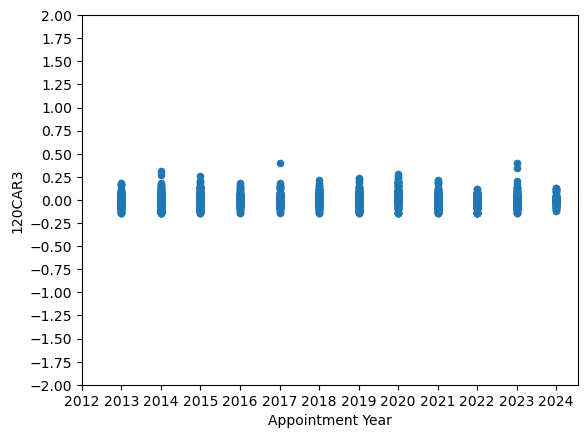

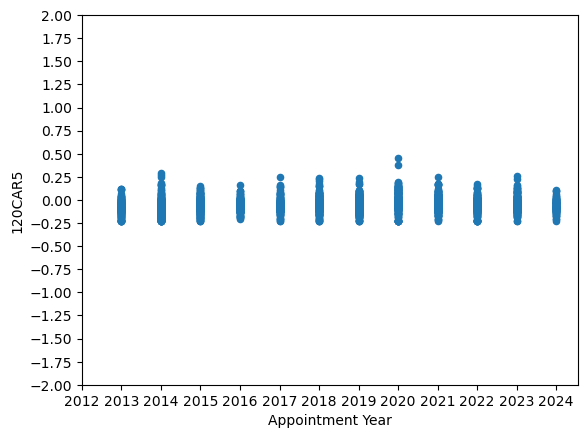

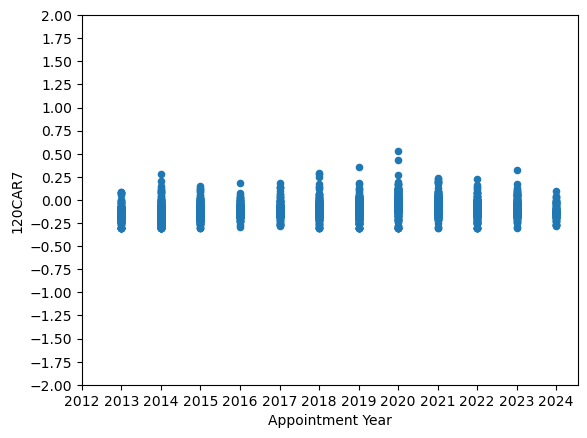

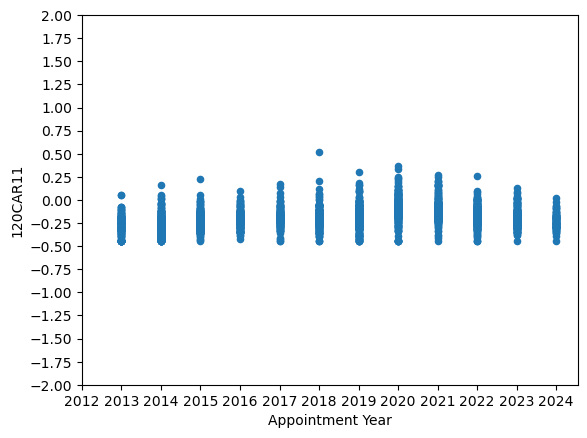

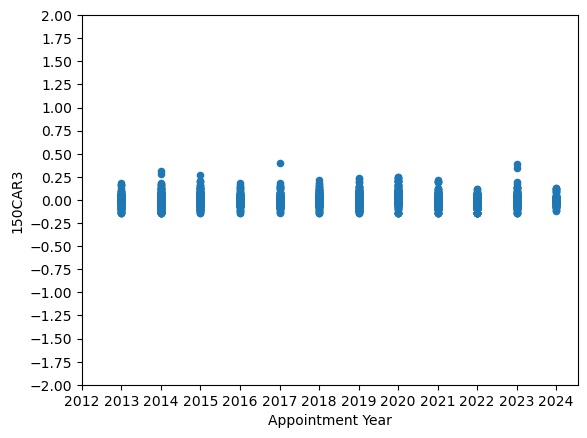

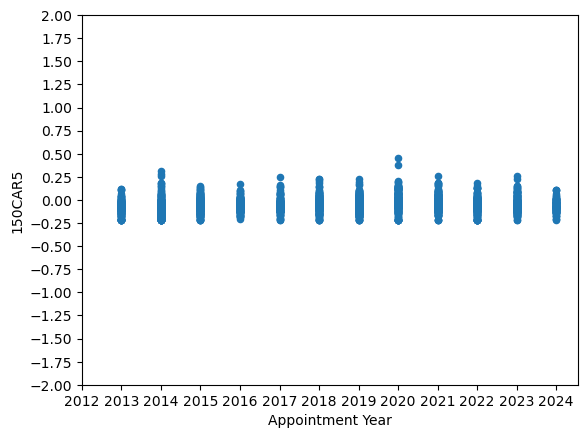

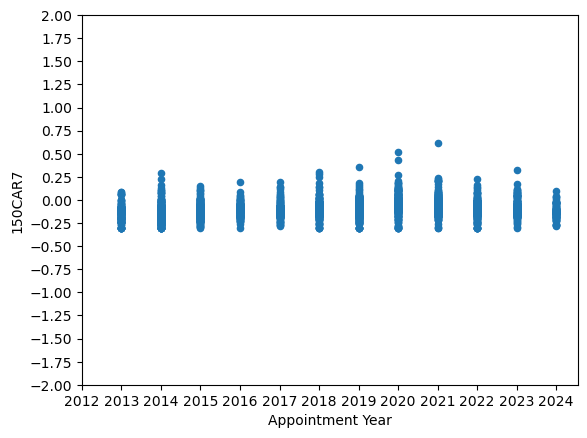

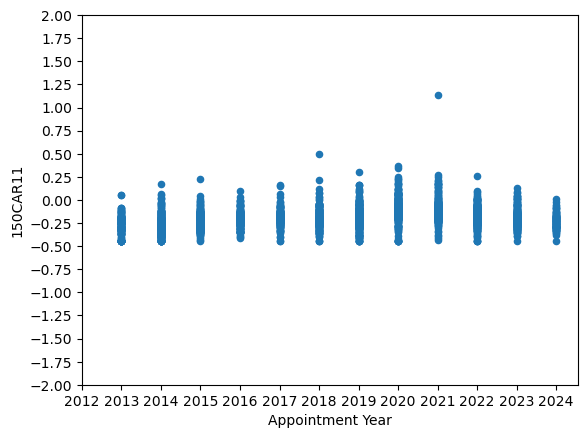

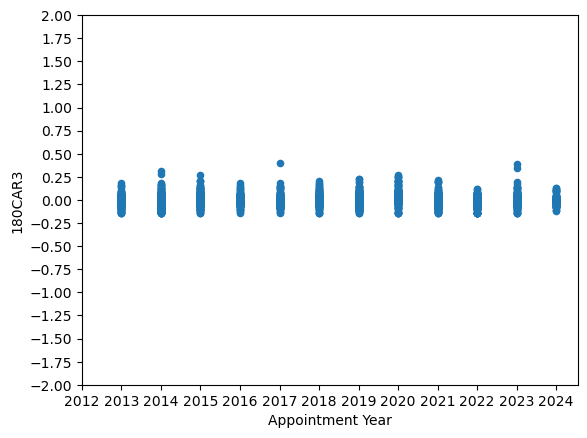

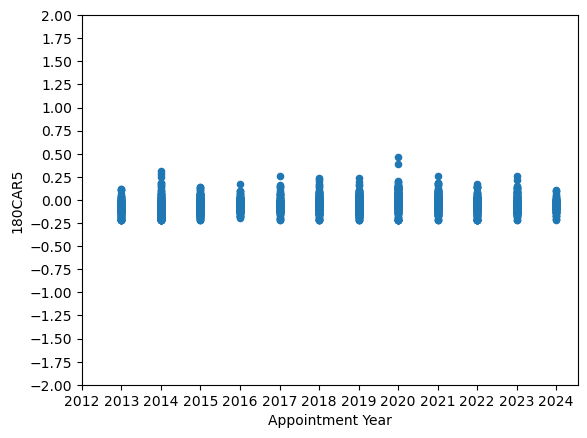

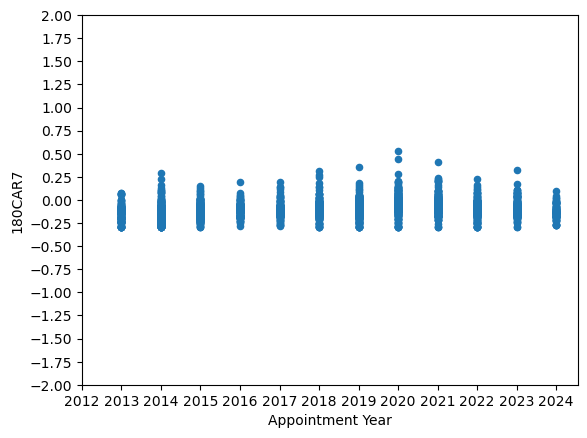

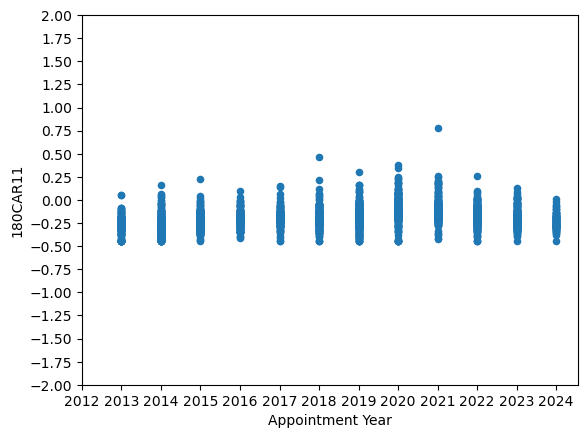

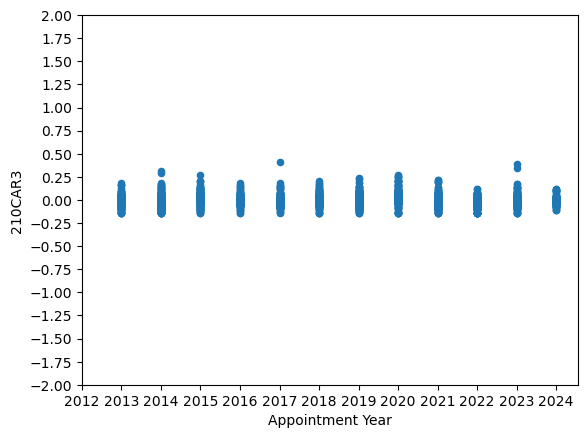

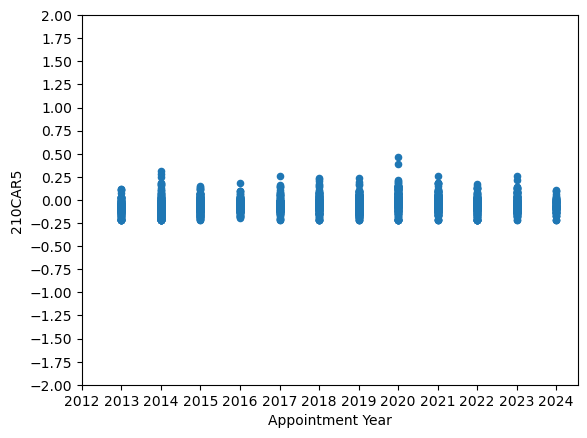

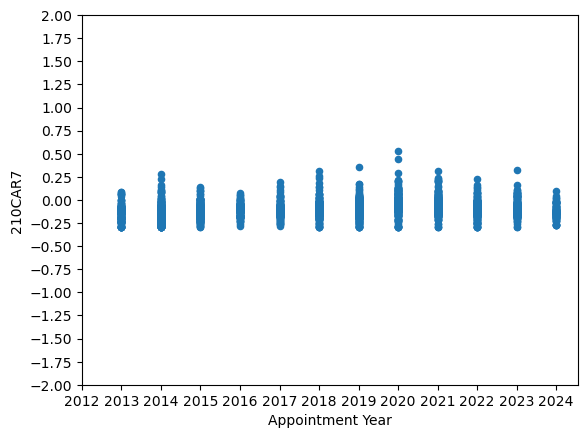

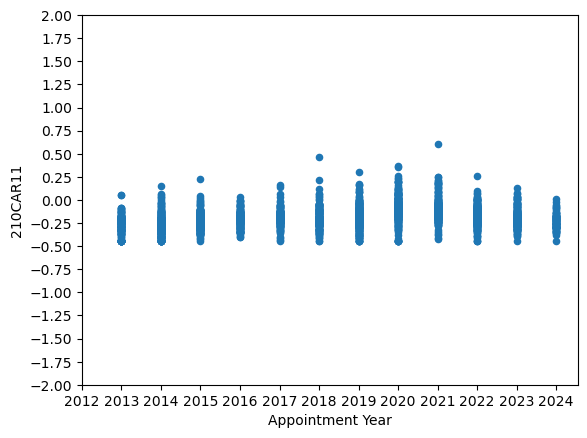

In [22]:
test = psmSampleIndep.loc[ psmSampleIndep["IsRookieIndep"] == 0 ].copy()

carCol = ["120CAR3", "120CAR5", "120CAR7", "120CAR11", 
          "150CAR3", "150CAR5", "150CAR7", "150CAR11", 
          "180CAR3", "180CAR5", "180CAR7", "180CAR11",
          "210CAR3", "210CAR5", "210CAR7", "210CAR11"]

for car in carCol:
    test[car] = winsorize(test[car].values, limits = [0.01, 0.01]).data
    test[[car, "Appointment Year"]].plot(kind = "scatter", x="Appointment Year", y=car, xticks = np.arange(2012, 2025, step = 1), yticks = np.arange(-2, 2.25, step = 0.25))

In [23]:
test.describe()

,AsOnDate,AsOnYear,Date of Birth,Tenure Valid till,Appointment Date,Cessation Date,PrevLastServed,NextServed,CessationDummy,ReappointDummy,TermStartDummy,TermNumber,AppointDummy,CumOpBalUnc,CumOpBalIndep,CumOpBalNonIndep,CumCloBalUnc,CumCloBalIndep,CumCloBalNonIndep,TermOpBalUnc,TermOpBalIndep,TermOpBalNonIndep,TermOpBalTotal,TermCloBalUnc,TermCloBalIndep,TermCloBalNonIndep,TermCloBalTotal,CompOpBalUnc,CompOpBalIndep,CompOpBalNonIndep,CompOpBalTotal,CompCloBalUnc,CompCloBalIndep,CompCloBalNonIndep,CompCloBalTotal,CloBalTotalXP,CountOtherPastUnclearA,CountOtherPastIndepA,CountOtherPastNonIndepA,CompCountOtherPastTotalA,CountOtherPastUnclearAB,CountOtherPastIndepAB,CountOtherPastNonIndepAB,CompCountOtherPastTotalAB,CountCurrUnclearA,CountCurrIndepA,CountCurrNonIndepA,CompCountCurrTotalA,CountCurrUnclearAB,CountCurrIndepAB,CountCurrNonIndepAB,CompCountCurrTotalAB,IsIndep,IsNonIndep,IsRookie,IsNonRookie,IsCeoMDPosition,IsChairmanPosition,IsCeoMDOccupation,IsChairmanOccupation,IsCeoMD,IsChairman,IsPromoterClassification,IsPromoterBoard,IsPromoter,IsDualityChairmanMD,IsFamilyManager,IsFamilyChairman,IsFamilyChairmanAndCEO,IsRookieIndep,IsRookieNonIndep,IsNonRookieIndep,IsNonRookieNonIndep,IsFemale,Age,TenureInYearsinCompIndep,TenureInYearsinCompTotal,IsFirstTerm,IsFirstTermIndep,IsOneYear,IsOneYearIndep,IsTwoYear,IsTwoYearIndep,IsThreeYear,IsThreeYearIndep,IsRetires5y,IsTermLimitRetirement,IsDefaultTerm,IsBusy,IsTurnOver,HasRetires5y,HasTermLimitRetirement,IsTurnOverIndep,Prowess company code,IsMBA,IsPhD,HasFinanceXP,HasTechXP,HasRelatedIndustryXP,IsExecCurrent,NumExecAll,IsOutsideExecXP,HasExecXP,PublicExecXPDummy,PrivateExecXPDummy,HasPublicExecXP,HasPrivateExecXP,HasTechSkill,HasFinanceSkill,NumSkills,NumFirmsPast,NumIndustryPast,HasCeoMDChairXP,HasConglomerateXP,skilllist_sustainability,skilllist_entrepreneurial,skilllist_compensation,skilllist_conglomerate_experience,skilllist_hr,skilllist_technology,skilllist_finance_accounting,skilllist_governance,skilllist_government_policy,skilllist_international,skilllist_leadership,skilllist_legal,skilllist_marketing,skilllist_risk_management,skilllist_scientific,skilllist_strategic_planning,skilllist_manufacturing_supply_chain,Academic,Manufacturing,Outside Board,Company Business,profile_sustainability,profile_entrepreneurial,profile_compensation,profile_conglomerate_experience,profile_hr,profile_technology,profile_finance_accounting,profile_governance,profile_government_policy,profile_international,profile_leadership,profile_legal,profile_marketing,profile_risk_management,profile_scientific,profile_strategic_planning,profile_manufacturing_supply_chain,committee_sustainability,committee_entrepreneurial,committee_compensation,committee_conglomerate_experience,committee_hr,committee_technology,committee_finance_accounting,committee_governance,committee_government_policy,committee_international,committee_leadership,committee_legal,committee_marketing,committee_risk_management,committee_scientific,committee_strategic_planning,committee_manufacturing_supply_chain,combined_sustainability,combined_entrepreneurial,combined_compensation,combined_conglomerate_experience,combined_hr,combined_technology,combined_finance_accounting,combined_governance,combined_government_policy,combined_international,combined_leadership,combined_legal,combined_marketing,combined_risk_management,combined_scientific,combined_strategic_planning,combined_manufacturing_supply_chain,NumSkills_dummies,Total No.of Board Meetings Held,No.of Meetings Attended,percent_board_absence,ProwessCode,ACP,pct,RF,RMRF,MF,SMB,HML,OLS120_intercept,OLS120_RMRF,OLS120_r_squared,OLS120_adjusted_r_squared,OLS120_f_p_value,120CAR3,120CAR5,120CAR7,120CAR11,OLS150_intercept,OLS150_RMRF,OLS150_r_squared,OLS150_adjusted_r_squared,OLS150_f_p_value,150CAR3,150CAR5,150CAR7,150CAR11,OLS180_intercept,OLS180_RMRF,OLS180_r_squared,OLS180_adjusted_r_squared,OLS180_f_p_value,180CAR3,180CAR5,180CAR7,180CAR11,OLS210_intercept,OLS210_RMRF,OLS210_r_squared,OLS

In [24]:
test.loc[ test["180CAR11"] >= 2]

,Symbol,Company,AsOnDate,AsOnYear,ISIN,Person Code,Director Salutation,Director First Name,Director Middle Name,Director Surname,Date of Birth,Gender,Nationality,Member of Civil Services,Promoter Director (Yes/No),Position on Board,Independent (Yes/No),Education1,Education2,Education3,Education4,Education5,Education6,Education7,Education8,Education9,Education10,Skills/Competencies,Occupation,Cessation Reason,Other Directorship 1,Other Directorship 2,Other Directorship 3,Other Directorship 4,Other Directorship 5,Other Directorship 6,Other Directorship 7,Other Directorship 8,Other Directorship 9,Other Directorship 10,Other Directorship 11,Other Directorship 12,Other Directorship 13,Other Directorship 14,Other Directorship 15,Brief Profile,Tenure Valid till,Indep,Appointment Date,Cessation Date,PrevLastServed,NextServed,CessationDummy,ReappointDummy,TermStartDummy,TermNumber,AppointDummy,CumOpBalUnc,CumOpBalIndep,CumOpBalNonIndep,CumCloBalUnc,CumCloBalIndep,CumCloBalNonIndep,TermOpBalUnc,TermOpBalIndep,TermOpBalNonIndep,TermOpBalTotal,TermCloBalUnc,TermCloBalIndep,TermCloBalNonIndep,TermCloBalTotal,CompOpBalUnc,CompOpBalIndep,CompOpBalNonIndep,CompOpBalTotal,CompCloBalUnc,CompCloBalIndep,CompCloBalNonIndep,CompCloBalTotal,CloBalTotalXP,AllPastDirect,CurrDirectA,CurrDirectAB,PastSiezedDirectA,PastSiezedDirectAB,CountOtherPastUnclearA,CountOtherPastIndepA,CountOtherPastNonIndepA,CompCountOtherPastTotalA,CountOtherPastUnclearAB,CountOtherPastIndepAB,CountOtherPastNonIndepAB,CompCountOtherPastTotalAB,CountCurrUnclearA,CountCurrIndepA,CountCurrNonIndepA,CompCountCurrTotalA,CountCurrUnclearAB,CountCurrIndepAB,CountCurrNonIndepAB,CompCountCurrTotalAB,Rookie,IsIndep,IsNonIndep,IsRookie,IsNonRookie,IsCeoMDPosition,IsChairmanPosition,IsCeoMDOccupation,IsChairmanOccupation,IsCeoMD,IsChairman,IsPromoterClassification,IsPromoterBoard,IsPromoter,IsDualityChairmanMD,IsFamilyManager,IsFamilyChairman,IsFamilyChairmanAndCEO,IsRookieIndep,IsRookieNonIndep,IsNonRookieIndep,IsNonRookieNonIndep,IsFemale,Age,TenureInYearsinCompIndep,TenureInYearsinCompTotal,IsFirstTerm,IsFirstTermIndep,IsOneYear,IsOneYearIndep,IsTwoYear,IsTwoYearIndep,IsThreeYear,IsThreeYearIndep,IsRetires5y,IsTermLimitRetirement,IsDefaultTerm,IsBusy,IsTurnOver,HasRetires5y,HasTermLimitRetirement,IsTurnOverIndep,NSE symbol,NIC code,Entity type,Ownership group,Prowess company code,CompanyName,Skills,EducationAll,IsMBA,IsPhD,AllPastDirectNIC,CurrDirectANIC,CurrDirectABNIC,AllNIC,AllNIC_Industry,HasFinanceXP,HasTechXP,HasRelatedIndustryXP,IsExecCurrent,NumExecAll,IsOutsideExecXP,HasExecXP,PublicExecXPDummy,PrivateExecXPDummy,HasPublicExecXP,HasPrivateExecXP,SkillsInPositiononBoard,SkillsInOccupation,AllSkills,HasTechSkill,HasFinanceSkill,FirmsPast,NumSkills,NumFirmsPast,NumIndustryPast,HasCeoMDChairXP,HasConglomerateXP,skilllist_sustainability,skilllist_entrepreneurial,skilllist_compensation,skilllist_conglomerate_experience,skilllist_hr,skilllist_technology,skilllist_finance_accounting,skilllist_governance,skilllist_government_policy,skilllist_international,skilllist_leadership,skilllist_legal,skilllist_marketing,skilllist_risk_management,skilllist_scientific,skilllist_strategic_planning,skilllist_manufacturing_supply_chain,Academic,Manufacturing,Outside Board,Company Business,profile_sustainability,profile_entrepreneurial,profile_compensation,profile_conglomerate_experience,profile_hr,profile_technology,profile_finance_accounting,profile_governance,profile_government_policy,profile_international,profile_leadership,profile_legal,profile_marketing,profile_risk_management,profile_scientific,profile_strategic_planning,profile_manufacturing_supply_chain,Committee Name,committee_sustainability,committee_entrepreneurial,committee_compensation,committee_conglomerate_experience,committee_hr,committee_technology,committee_finance_accounting,committee_governance,committee_government_policy,committee_international,committee_leadership,committee_legal,committee_marketing,committee_risk_management,co

## Panel A: Whole Sample

### Mean Difference

In [25]:
carCol = ["120CAR3", "120CAR5", "120CAR7", "120CAR11", 
          "150CAR3", "150CAR5", "150CAR7", "150CAR11", 
          "180CAR3", "180CAR5", "180CAR7", "180CAR11",
          "210CAR3", "210CAR5", "210CAR7", "210CAR11"]

exog_var = None
depVar = None
controlVars = None

for car in carCol:
    sample = psmSampleIndep.dropna(subset = car).reset_index(drop=True).copy()
    MeanDiffTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)



120CAR3 :


T Statistic: -0.36201827747603976  P Value: 0.7173506011471915
Treated Mean: -0.0021313756521390633  Control Mean: -0.0016222135895892086  Diff: -0.0005091620625498547
Treated Median: -0.004940889308714731  Control Median: -0.0037739144244691714  Diff: -0.00116697488424556
Treated N: 5477 ; Control N: 2899
[treated unique =  5477 ] [control unique =  2899 ]




120CAR5 :


T Statistic: -0.12193249104277526  P Value: 0.9029563250800555
Treated Mean: -0.05180770941309266  Control Mean: -0.05159326436612489  Diff: -0.00021444504696777056
Treated Median: -0.0533085314720004  Control Median: -0.052751464016560355  Diff: -0.0005570674554400482
Treated N: 5475 ; Control N: 2897
[treated unique =  5475 ] [control unique =  2897 ]




120CAR7 :


T Statistic: -0.5395016690530052  P Value: 0.5895592855857426
Treated Mean: -0.10033299529393896  Control Mean: -0.09919339084574647  Diff: -0.0011396044481924994
Treated Median: -0.10094745653743162  Control Median: -0.09860220164473066 

In [26]:
### PSM without replacement
# PsmNonReplac(psmSampleIndep, "RookieIndepAppointDummy", controlVars, "ln_TobinQ_longborrowincl2", dirFirm)

### One Sample T Test

In [27]:
carCol = ["120CAR3", "120CAR5", "120CAR7", "120CAR11", 
          "150CAR3", "150CAR5", "150CAR7", "150CAR11", 
          "180CAR3", "180CAR5", "180CAR7", "180CAR11",
          "210CAR3", "210CAR5", "210CAR7", "210CAR11"]

exog_var = None
depVar = None
controlVars = None

for car in carCol:
    sample1 = psmSampleIndep.loc[psmSampleIndep["IsRookieIndep"] == 1].copy()
    print("Rookie Independent Directors:")
    sample = sample1.dropna(subset = car).reset_index(drop=True).copy()
    OneSampleTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

    sample2 = psmSampleIndep.loc[psmSampleIndep["IsRookieIndep"] == 0].copy()
    print("Non Rookie Independent Directors:")
    sample = sample2.dropna(subset = car).reset_index(drop=True).copy()
    OneSampleTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)


Rookie Independent Directors:


120CAR3 :


T Statistic: -2.5264287441659383  P Value: 0.011550823172169822
Mean: -0.002190787372035788
Median: -0.004940889308714731
N: 5477


Non Rookie Independent Directors:


120CAR3 :


T Statistic: -1.4364974687212073  P Value: 0.15096877676630888
Mean: -0.0015856990562138585
Median: -0.0037739144244691714
N: 2899


Rookie Independent Directors:


120CAR5 :


T Statistic: -46.50940735660638  P Value: 0.0
Mean: -0.0516620350506676
Median: -0.0533085314720004
N: 5475


Non Rookie Independent Directors:


120CAR5 :


T Statistic: -38.116697002708364  P Value: 5.27478956202432e-258
Mean: -0.051622458900727544
Median: -0.052751464016560355
N: 2897


Rookie Independent Directors:


120CAR7 :


T Statistic: -73.9655481312013  P Value: 0.0
Mean: -0.10003260065377434
Median: -0.10094745653743162
N: 5473


Non Rookie Independent Directors:


120CAR7 :


T Statistic: -61.54852450407749  P Value: 0.0
Mean: -0.09921169647022525
Median: -0.09860220164473066
N: 

## Panel B: Unique skills dummy

### Mean Difference: RID vs NRID

In [28]:
carCol = ["120CAR3", "120CAR5", "120CAR7", "120CAR11", 
          "150CAR3", "150CAR5", "150CAR7", "150CAR11", 
          "180CAR3", "180CAR5", "180CAR7", "180CAR11",
          "210CAR3", "210CAR5", "210CAR7", "210CAR11"]

exog_var = None
depVar = None
controlVars = None

for car in carCol:
    print("No unique skills:")
    sample = psmSampleIndep.loc[psmSampleIndep["NumSkills_dummies"] == 0].dropna(subset = car).reset_index(drop=True).copy()
    MeanDiffTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

    print("At least one unique skill:")
    sample = psmSampleIndep.loc[psmSampleIndep["NumSkills_dummies"] != 0].dropna(subset = car).reset_index(drop=True).copy()
    MeanDiffTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

No unique skills:


120CAR3 :


T Statistic: 0.05841404450466805  P Value: 0.9538444151312024
Treated Mean: -0.00032411183577051847  Control Mean: -0.0011020667073827156  Diff: 0.0007779548716121971
Treated Median: -0.0011348484277578785  Control Median: -0.01252680155495365  Diff: 0.011391953127195771
Treated N: 215 ; Control N: 22
[treated unique =  215 ] [control unique =  22 ]


At least one unique skill:


120CAR3 :


T Statistic: -0.44250710441131075  P Value: 0.6581375935171707
Treated Mean: -0.0022470309587305747  Control Mean: -0.0016186716156375714  Diff: -0.0006283593430930032
Treated Median: -0.005210222497984463  Control Median: -0.0037083411075354775  Diff: -0.0015018813904489857
Treated N: 5262 ; Control N: 2877
[treated unique =  5262 ] [control unique =  2877 ]


No unique skills:


120CAR5 :


T Statistic: -0.3889546444473521  P Value: 0.7003934389496
Treated Mean: -0.07197825233239522  Control Mean: -0.06405543350912703  Diff: -0.007922818823268188
Treated Median: -0

### Mean Difference: within RID/NRID: WIP

In [29]:
# carCol = ["120CAR3", "120CAR5", "120CAR7", "120CAR11", 
#           "150CAR3", "150CAR5", "150CAR7", "150CAR11", 
#           "180CAR3", "180CAR5", "180CAR7", "180CAR11",
#           "210CAR3", "210CAR5", "210CAR7", "210CAR11"]

# exog_var = None
# depVar = None
# controlVars = None

# for car in carCol:
#     print("No unique skills:")
#     sample = psmSampleIndep.loc[psmSampleIndep["NumSkills_dummies"] == 0].dropna(subset = car).reset_index(drop=True).copy()
#     MeanDiffTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

#     print("At least one unique skill:")
#     sample = psmSampleIndep.loc[psmSampleIndep["NumSkills_dummies"] != 0].dropna(subset = car).reset_index(drop=True).copy()
#     MeanDiffTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

### One Sample T Test

In [30]:
carCol = ["120CAR3", "120CAR5", "120CAR7", "120CAR11", 
          "150CAR3", "150CAR5", "150CAR7", "150CAR11", 
          "180CAR3", "180CAR5", "180CAR7", "180CAR11",
          "210CAR3", "210CAR5", "210CAR7", "210CAR11"]

exog_var = None
depVar = None
controlVars = None

for car in carCol:
    sample1 = psmSampleIndep.loc[psmSampleIndep["IsRookieIndep"] == 1].copy()
    print("Rookie Independent Directors\nNo unique skills:")
    sample = sample1.loc[sample1["NumSkills_dummies"] == 0].dropna(subset = car).reset_index(drop=True).copy()
    OneSampleTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

    print("At least one unique skill:")
    sample = sample1.loc[sample1["NumSkills_dummies"] != 0].dropna(subset = car).reset_index(drop=True).copy()
    OneSampleTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

    sample2 = psmSampleIndep.loc[psmSampleIndep["IsRookieIndep"] == 0].copy()
    print("Non Rookie Independent Directors\nNo unique skills:")
    sample = sample2.loc[sample2["NumSkills_dummies"] == 0].dropna(subset = car).reset_index(drop=True).copy()
    OneSampleTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

    print("At least one unique skill:")
    sample = sample2.loc[sample2["NumSkills_dummies"] != 0].dropna(subset = car).reset_index(drop=True).copy()
    OneSampleTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

Rookie Independent Directors
No unique skills:


120CAR3 :


T Statistic: -0.06919655019684995  P Value: 0.9448977834943393
Mean: -0.00032411183577051847
Median: -0.0011348484277578785
N: 215


At least one unique skill:


120CAR3 :


T Statistic: -2.603885249334697  P Value: 0.009243265619990192
Mean: -0.0023007579271198237
Median: -0.005210222497984463
N: 5262


Non Rookie Independent Directors
No unique skills:


120CAR3 :


T Statistic: -0.08839805755202777  P Value: 0.9303978903527932
Mean: -0.0011020667073827156
Median: -0.01252680155495365
N: 22


At least one unique skill:


120CAR3 :


T Statistic: -1.4339575512807845  P Value: 0.15169308791482286
Mean: -0.0015893973223502099
Median: -0.0037083411075354775
N: 2877


Rookie Independent Directors
No unique skills:


120CAR5 :


T Statistic: -10.46580531804095  P Value: 5.7615859915160384e-21
Mean: -0.07197825233239522
Median: -0.062254546100024094
N: 215


At least one unique skill:


120CAR5 :


T Statistic: -45.32789607860907 

In [31]:
### PSM without replacement
# PsmNonReplac(psmSampleIndep, "RookieIndepAppointDummy", controlVars, "ln_TobinQ_longborrowincl2", dirFirm)

## Panel C: Number of Skills

### Mean Difference

In [32]:
carCol = ["120CAR3", "120CAR5", "120CAR7", "120CAR11", 
          "150CAR3", "150CAR5", "150CAR7", "150CAR11", 
          "180CAR3", "180CAR5", "180CAR7", "180CAR11",
          "210CAR3", "210CAR5", "210CAR7", "210CAR11"]

exog_var = None
depVar = None
controlVars = None

num_skills_median = psmSampleIndep.drop_duplicates(subset = ["AsOnDate", "Person Code"])["NumSkills_dummies"].median()
for car in carCol:
    print("Less than median no. skills:")
    sample = psmSampleIndep.loc[psmSampleIndep["NumSkills_dummies"] < num_skills_median].dropna(subset = car).reset_index(drop=True).copy()
    MeanDiffTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

    print("Greater than median no. skills:")
    sample = psmSampleIndep.loc[psmSampleIndep["NumSkills_dummies"] > num_skills_median].dropna(subset = car).reset_index(drop=True).copy()
    MeanDiffTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

Less than median no. skills:


120CAR3 :


T Statistic: -1.7050995347615068  P Value: 0.0887299551910241
Treated Mean: -0.0030334955844022117  Control Mean: 0.00281273876983716  Diff: -0.005846234354239372
Treated Median: -0.005492238941345415  Control Median: -0.0037144405365002638  Diff: -0.001777798404845151
Treated N: 2647 ; Control N: 418
[treated unique =  2647 ] [control unique =  418 ]


Greater than median no. skills:


120CAR3 :


T Statistic: 0.7148289396252002  P Value: 0.4747507588092902
Treated Mean: -0.0012742314304100932  Control Mean: -0.0025413369765904543  Diff: 0.001267105546180361
Treated Median: -0.002964572491104229  Control Median: -0.004098703761218958  Diff: 0.0011341312701147292
Treated N: 2304 ; Control N: 2355
[treated unique =  2304 ] [control unique =  2355 ]


Less than median no. skills:


120CAR5 :


T Statistic: 1.0190287241119476  P Value: 0.3086186636938809
Treated Mean: -0.0581991988271332  Control Mean: -0.06256605903824289  Diff: 0.00436686021110

### One Sample T Test

In [33]:
carCol = ["120CAR3", "120CAR5", "120CAR7", "120CAR11", 
          "150CAR3", "150CAR5", "150CAR7", "150CAR11", 
          "180CAR3", "180CAR5", "180CAR7", "180CAR11",
          "210CAR3", "210CAR5", "210CAR7", "210CAR11"]

exog_var = None
depVar = None
controlVars = None

num_skills_median = psmSampleIndep.drop_duplicates(subset = ["AsOnDate", "Person Code"])["NumSkills_dummies"].median()
for car in carCol:
    sample1 = psmSampleIndep.loc[psmSampleIndep["IsRookieIndep"] == 1].copy()
    print("Rookie Independent Directors\nLess than median no. skills:")
    sample = sample1.loc[sample1["NumSkills_dummies"] < num_skills_median].dropna(subset = car).reset_index(drop=True).copy()
    OneSampleTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

    print("Greater than median no. skills:")
    sample = sample1.loc[sample1["NumSkills_dummies"] < num_skills_median].dropna(subset = car).reset_index(drop=True).copy()
    OneSampleTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

    sample2 = psmSampleIndep.loc[psmSampleIndep["IsRookieIndep"] == 0].copy()
    print("Non Rookie Independent Directors\nLess than median no. skills:")
    sample = sample2.loc[sample2["NumSkills_dummies"] > num_skills_median].dropna(subset = car).reset_index(drop=True).copy()
    OneSampleTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

    print("Greater than median no. skills:")
    sample = sample2.loc[sample2["NumSkills_dummies"] > num_skills_median].dropna(subset = car).reset_index(drop=True).copy()
    OneSampleTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

Rookie Independent Directors
Less than median no. skills:


120CAR3 :


T Statistic: -2.402165207714295  P Value: 0.01636686240688458
Mean: -0.0030794867122340397
Median: -0.005492238941345415
N: 2647


Greater than median no. skills:


120CAR3 :


T Statistic: -2.402165207714295  P Value: 0.01636686240688458
Mean: -0.0030794867122340397
Median: -0.005492238941345415
N: 2647


Non Rookie Independent Directors
Less than median no. skills:


120CAR3 :


T Statistic: -2.091779625240198  P Value: 0.0365651409767436
Mean: -0.0025372577140872314
Median: -0.004098703761218958
N: 2355


Greater than median no. skills:


120CAR3 :


T Statistic: -2.091779625240198  P Value: 0.0365651409767436
Mean: -0.0025372577140872314
Median: -0.004098703761218958
N: 2355


Rookie Independent Directors
Less than median no. skills:


120CAR5 :


T Statistic: -34.79974780021493  P Value: 8.25160644925417e-219
Mean: -0.05804026769095097
Median: -0.05861745389548872
N: 2647


Greater than median no. skills:


12

In [34]:
### PSM without replacement
# PsmNonReplac(psmSampleIndep, "RookieIndepAppointDummy", controlVars, "ln_TobinQ_longborrowincl2", dirFirm)